# IndiaMart PriceRangePrediction

New Section


```
# To Achieve the target, we have assumed the following things:

      1. 85% and above prices should be retained after outlier detection for finding the price range.
      2. Units which have counts < 5 are removed.
     
```


```
# The following ensemble technique is used to find outliers:

        1. Isolation Forests - IF
        2. DBScan
        3. LOF
        4. MaxVote(IF, DBScan, LOF)
```

```

# For estimation of amount of contamination, Inter-Quartile Range Data is considered. If Data(IQR)==100%, it is set to 98% and if <=85%, it is set to 87%
```

The **contamination**  factor and **epsilon** value are not fixed and infered dynamically by the above technique. Primary test indicate robust nature of this technique.


##Imports

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats


##Data Preprocessing

1. Remove items with count < 5
2. Consolidation and Organization

In [0]:
data = pd.read_csv("Data-Table 1.csv")

In [0]:
data = data.drop(columns={"Subcat name", "PC_ITEM_ID", "PC_ITEM_NAME", })
data  = data.rename(index=str, columns={"Mcat Name": "MCAT", "FK_IM_SPEC_MASTER_DESC": "ISQ", "FK_IM_SPEC_OPTIONS_DESC":"ISQ Options", "PC_ITEM_FOB_PRICE":"Prices","PC_ITEM_MOQ_UNIT_TYPE":"Unit"})
data.head()


#for non isq
data1=data.drop(columns={"ISQ", "ISQ Options"})
data1 = data1.groupby(['MCAT','Unit'])
data1 = data1.filter(lambda x: x['Unit'].count() > 5)
data1 = data1.groupby(['MCAT','Unit'])


#for isq
data2 = data.groupby(['MCAT','Unit','ISQ','ISQ Options'])
data2 = data2.filter(lambda x: x['ISQ Options'].count() > 5)
data2 = data2.groupby(['MCAT','Unit','ISQ','ISQ Options'])

In [395]:
data1.describe()

Prices  ...            
                                                   count  ...         max
MCAT                               Unit                   ...            
AC Motors                          Number           10.0  ...     25000.0
                                   Piece           113.0  ...    100000.0
                                   Unit             40.0  ...    100000.0
Acme Safety Shoes                  Box               6.0  ...       860.0
                                   Pair            251.0  ...      1911.0
                                   Piece            19.0  ...       699.0
                                   Unit             15.0  ...       720.0
Air Conditioner Voltage Stabilizer Box              18.0  ...      4150.0
                                   Piece            87.0  ...     79000.0
                                   Unit             37.0  ...      7500.0
Air Spray Gun                      Piece            92.0  ...     74000.0
                                   Unit             30.0  ...     36000.0
Aluminium False Ceilings           Number            7.0  ...       200.0
                                   Piece            15.0  ...      5000.0
                                   Square Feet     103.0  ...       300.0
                                   Square Feet(s)    7.0  ...        75.0
                                   Square Meter      6.0  ...       650.0
Aluminium Melting Furnace          Piece            33.0  ...   1150000.0
                                   Unit             45.0  ...   2000000.0
Aluminum Cables                    Meter           166.0  ...      1011.0
                                   Roll             22.0  ...       900.0
Audio Amplifiers                   Piece           224.0  ...    103000.0
                                   Unit              7.0  ...     42000.0
Backhoe Loader                     Hour              7.0  ...       900.0
                                   No                7.0  ...    100000.0
                                   Number           18.0  ...   2690000.0
                                   Piece            76.0  ...   2600000.0
                                   Set               9.0  ...  25000000.0
                                   Unit            102.0  ...   2795000.0
                                   one               8.0  ...   2550000.0
...                                                  ...  ...         ...
Tube Filling Machine               Unit             42.0  ...   1100000.0
Twisted Yarn                       Kilogram         83.0  ...      4000.0
Vertical Form Fill Seal Machines   Number            7.0  ...   1200000.0
                                   Piece            31.0  ...    360000.0
                                   Set               7.0  ...   2610000.0
                                   Unit             21.0  ...    400000.0
Water Demineralization Plant       Number            9.0  ...    250000.0
                                   Piece            30.0  ...    750000.0
                                   Set               9.0  ...    600000.0
                                   Unit             96.0  ...    572000.0
Water Packaging Machine            Pair             12.0  ...    550000.0
                                   Piece            92.0  ...   1500000.0
                                   Set              12.0  ...   1500000.0
                                   Unit             58.0  ...   1250000.0
                                   nos               8.0  ...     40000.0
Wheel Loader                       No                6.0  ...   1600000.0
                                   Piece            53.0  ...   5900000.0
                                   Unit             50.0  ...  15000000.0
Wire Drawing Machines              1 Unit            6.0  ...    630000.0
                                   Piece            59.0  ...   1000000.0
                                   Set               8

In [396]:
data2.describe()

Prices  ...           
                                                                                                 count  ...        max
MCAT                               Unit        ISQ                     ISQ Options                      ...           
AC Motors                          Piece       No of Phase             Three Phase                12.0  ...   100000.0
                                   Unit        No of Phase             Three Phase                 6.0  ...    20000.0
Acme Safety Shoes                  Pair        Brand                   Acme                       18.0  ...     1850.0
                                               Certification           CE                          6.0  ...     1100.0
                                                                       ISI                         6.0  ...     1850.0
                                               Color                   Black                      37.0  ...     1650.0
                                               Length                  Low ankle                  16.0  ...     1911.0
                                               Material                Leather                    20.0  ...     1911.0
                                               Size                    7                           7.0  ...     1911.0
                                                                       All Sizes                  15.0  ...     1850.0
                                               Sole                    PU                         20.0  ...     1911.0
                                               Sole Type               PU                          9.0  ...     1100.0
                                   Piece       Color                   Black, Brown                6.0  ...      200.0
Air Conditioner Voltage Stabilizer Piece       Power                   4KVA                       11.0  ...     3500.0
                                                                       5KVA                        9.0  ...     4000.0
Aluminium False Ceilings           Square Feet Color                   White                      11.0  ...      300.0
                                               Material                Aluminum                   18.0  ...      250.0
Aluminium Melting Furnace          Piece       Melting Material        Aluminium                   9.0  ...  1150000.0
                                               Power Source            Electric                    6.0  ...   600000.0
                                   Unit        Melting Material        Aluminium                   9.0  ...  2000000.0
                                               Power Source            Electric                   10.0  ...  2000000.0
Aluminum Cables                    Meter       Conductor Type          Solid                       7.0  ...       50.0
                                               Is It Armoured          Armoured                   11.0  ...     1011.0
                                               Power/Voltage           230 Volt                   11.0  ...       85.0
Audio Amplifiers                   Piece       Brand                   APART AUDIO                 6.0  ...    58300.0
                                                                       BOSCH                       9.0  ...    31746.0
                                                                       RBM                         6.0  ...    12200.0
                                               Channel                 2                           6.0  ...    43000.0
Backhoe Loader                     Unit        Condition               Brand New                  13.0  ...  2750000.0
Bag Filling Machine                Unit        Brand                   Kvson                      10.0  ...   375000.0
...                                                                                                ...  ...        ...
Tractor Front End Loader           Piece       Con

# Driver Program

**The Main Ensembled Function**

In [0]:
chunks = []
names = []

for name,c in data1:
  chunks.append(pd.DataFrame({"Price":c['Prices']}))
  names.append(name)
  
chunks2 = []
names2 = []
for name,c in data2:
  chunks2.append(pd.DataFrame({"Price":c['Prices']}))
  names2.append(name)

col_names =  ['MCAT Name', 'Unit', 'Unit Wise Min Price', 'Unit Wise Max Price', 'Most Common Price 1', 'Most Common Price 2', 'Most Common Price 3']
my_df1  = pd.DataFrame()
my_df2  = pd.DataFrame()

In [0]:
def findPriceRange(datas,contamination_factor,seed_percentage):
    
    datas = datas.sort_values(by=['Price'])
    datax = datas
    datay = datas
    dataz = datas
    
    original_std = np.std(np.array(datas))
    
    print("Seed Percentage :",seed_percentage, end=" ")
    print("Contamination: ",contamination_factor)
    print("original_std : ",original_std)
                      

    ######_____Isolation Forests

    isolation_forest = IsolationForest(contamination=contamination_factor, behaviour="new")
    if_vote = isolation_forest.fit_predict(dataz['Price'].values.reshape(-1,1))
    ######_____DBScan
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.cluster import DBSCAN
     
    scaler = MinMaxScaler()
    sd = scaler.fit_transform(datax)
    sd = pd.DataFrame(sd,columns=['Price'])
    
    
    outlier_detection = DBSCAN(eps = getHyperparameters(sd,seed_percentage) ,metric="euclidean",min_samples = 3,n_jobs = -1)
    clusters = outlier_detection.fit_predict(sd)
    clusters[clusters!=-1]=1
    
    dbscan_vote = clusters
    
    ######_____Local Outlier Factor
    clf = LocalOutlierFactor(n_neighbors=20, contamination=contamination_factor)
    y_pred = clf.fit_predict(np.array(datay['Price']).reshape(-1,1))
    X_scores = clf.negative_outlier_factor_

    lof_vote = y_pred
    
    ###genetic mixing
    
    
    v1 = if_vote 
    v1[v1>0] = 1
    v1[v1<0]=0
   
    v2 = dbscan_vote
    v2[v2>0] = 1
    v2[v2<0] = 0
                        
    v3 = lof_vote

    v3[v3>0] = 1
    v3[v3<0] = 0
    
      
    v4 = v1 + v2
    v4[v4>0] = 1
    v4[v4<0] = 0
    
    v5 = v2 + v3
    v5[v5>0] = 1
    v5[v5<0] = 0                      
                          
    v6 = v1 + v3
    v6[v6>0] = 1
    v6[v6<0] = 0 
     
    v7 = v1 + v2 + v3
    
    v7[v7<2] = 0
    v7[v7!=0] = 1
    
    
    l = ["v1", "v2", "v3", "v4", "v5", "v6", "v7"]
    index = {"v1":v1, "v2":v2, "v3":v3, "v4":v4, "v5":v5, "v6":v6, "v7":v7}
    
    minn = original_std+1
    best = []
    k = 0
    for i in l:
        
        t = index[i]*np.array(dataz['Price'])
        t = np.trim_zeros(t)
        k  = np.std(np.array(t))
        if(k<minn):
          minn = k
          best = t
    
    min_price, max_price = np.min(best), np.max(best)           
        


    return(min_price, max_price, best)
    

In [0]:
def threeModes(dataChunk):
  
  dataChunk2 = dataChunk
  m1=0
  m2=0
  m3=0
 
  m1 = int(stats.mode(dataChunk2)[0])
  dataChunk2 = dataChunk2[dataChunk2 != m1]
  
  if(len(dataChunk2)!=0):
    m2 = int(stats.mode(dataChunk2)[0])
    
    dataChunk2 = dataChunk2[dataChunk2 != m2]
  if(len(dataChunk2)!=0):
    m3 = int(stats.mode(dataChunk2)[0])
  


  return([m1, m2, m3])
  

In [0]:

def plot_figure(x,c,u,min_price,max_price):
    
    k = x
    fig, ax = plt.subplots()
    num_bins = 10
    n, bins, patches = ax.hist(k['Price'], num_bins, color=['grey'])
    d = ax.fill_betweenx(n,min_price,max_price,color='g',alpha=0.5)
    ax.set_xlabel('Prices')
    ax.set_ylabel('Counts')
    ax.set_title(r'Histogram for item-'+ c +' and unit - '+ u)
    fig.tight_layout()
    plt.show()

def getHyperparameters(sd,retain):
  
  import math
  
  dis=[]
  temp =list(sd['Price'])
  for i in range(0,len(temp)-1):
    dis.append(temp[i+1]-temp[i])

  arr = np.array(dis)
  diss = pd.DataFrame(dis,columns=['dis'])
  std=diss['dis'].std()
  ma = diss['dis'].max()
  n=len(dis)
  
  cnt={}
  unique_dis=list(set(dis))
  for i in unique_dis:
    cnt[i]=dis.count(i)
  keys = cnt.keys()
  keys=sorted(keys)
  cands=[]
  full = int(round((retain*n),0))
  for i in keys:
    full = full - cnt[i]
    cands.append(i)
    if(full<=0):
      break
    
  
  b = pd.DataFrame(cands)
  epsilon = round(np.max(np.array(b))*1000,0)/1000
  
  if(epsilon==0):
    epsilon=0.5
    
  print("Epsilon: ",epsilon)
  return(epsilon)
  

In [0]:
def estimateContamination(dataChunk):
  
  #index column addition
  unnormal_data=pd.DataFrame(dataChunk)

  # Computing IQR
  Q1 = unnormal_data['Price'].quantile(0.25)
  Q3 = unnormal_data['Price'].quantile(0.75)
  IQR = Q3 - Q1 

  import random
  label_data = list(unnormal_data['Price'])
  t=[]
  for i in range(len(unnormal_data['Price'])):
    if( (label_data[i] <= (Q1 - 1.5 * IQR)) or (label_data[i] >= (Q3 + 1.5 * IQR))):
      pass
    else:
      t.append(label_data[i])

  filtered = t
  
  
  #keep seed percentage == IQR range or 85% or 98%
  #assume 85%-98% purityz
  

 # double IQR
  
  import math
    
  seed_percentage  = math.floor((len(filtered)/len(unnormal_data))*100)
  if(seed_percentage<=85):
    seed_percentage = 88
  elif(seed_percentage>=99):
    seed_percentage = 88
    
  contamination_factor=0.5*((100-seed_percentage)/100) 
   


  
  return([seed_percentage, contamination_factor, filtered])

In [403]:
debug = 0

for i in range(len(chunks)):
  contam = estimateContamination(chunks[i])
  minn, maxx, pdata = findPriceRange(chunks[i],contam[1], contam[0])
  t = threeModes(pdata)
  my_df1 = my_df1.append({'MCAT Name': names[i][0], 'Unit': names[i][1], 'Unit Wise Min Price': minn, 'Unit Wise Max Price': maxx, 'Most Common Price 1':t[0], 'Most Common Price 2':t[1], 'Most Common Price 3':t[2] }, ignore_index=True)

for i in range(len(chunks2)):
  
  contam = estimateContamination(chunks2[i])
  minn, maxx, pdata = findPriceRange(chunks2[i],contam[1], contam[0])
  my_df2 = my_df2.append({'MCAT Name': names2[i][0], 'Unit': names2[i][1], 'ISQ Name' : names2[i][2], 'ISQ Options' :names2[i][3], 'ISQ Min Price': minn, 'ISQ Max Price': maxx}, ignore_index=True)

my_df1 = my_df1[col_names]
my_df2 = my_df2[['MCAT Name', 'Unit', 'ISQ Name', 'ISQ Options', 'ISQ Min Price', 'ISQ Max Price']]
  



Seed Percentage : 88 Contamination:  0.06
original_std :  1469.6938456699068
Epsilon:  1.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Seed Percentage : 91 Contamination:  0.045
original_std :  15974.786521555538
Epsilon:  0.6
Seed Percentage : 95 Contamination:  0.025
original_std :  21034.83360404831
Epsilon:  0.735
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 95 Contamination:  0.025
original_std :  364.83785838384773


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.117
Seed Percentage : 88 Contamination:  0.06
original_std :  170.23602647248694
Epsilon:  0.399
Seed Percentage : 93 Contamination:  0.035
original_std :  44.34210439550904


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.778
Seed Percentage : 88 Contamination:  0.06
original_std :  1400.1543124832465


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.584
Seed Percentage : 88 Contamination:  0.06
original_std :  14023.457687487398


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.875
Seed Percentage : 88 Contamination:  0.06
original_std :  2209.131587194346
Epsilon:  0.352
Seed Percentage : 88 Contamination:  0.06
original_std :  13710.924634146722
Epsilon:  0.704
Seed Percentage : 88 Contamination:  0.06
original_std :  13389.802919469063
Epsilon:  0.544
Seed Percentage : 88 Contamination:  0.06
original_std :  24.743582965269674
Epsilon:  1.0
Seed Percentage : 93 Contamination:  0.035
original_std :  1206.2198067608667


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.954
Seed Percentage : 88 Contamination:  0.06
original_std :  72.99550606795907


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.172
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  339906.47176840564


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.364
Seed Percentage : 88 Contamination:  0.06
original_std :  619505.976017171
Epsilon:  0.342
Seed Percentage : 88 Contamination:  0.06
original_std :  256.5048214671848
Epsilon:  0.333
Seed Percentage : 88 Contamination:  0.06
original_std :  273.2688751013799
Epsilon:  0.264
Seed Percentage : 94 Contamination:  0.03
original_std :  21192.478460280694
Epsilon:  0.16
Seed Percentage : 88 Contamination:  0.06
original_std :  14807.56935503196
Epsilon:  0.57
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  318436.0896787243


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.321
Seed Percentage : 88 Contamination:  0.06
original_std :  800494.424777414


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.175
Seed Percentage : 88 Contamination:  0.06
original_std :  11455129.85522207
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  809144.2320327067


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.186
Seed Percentage : 88 Contamination:  0.06
original_std :  824242.0760917268
Epsilon:  0.9
Seed Percentage : 88 Contamination:  0.06
original_std :  445749.0574552258


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.791
Seed Percentage : 93 Contamination:  0.035
original_std :  88850.6030974942


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.759
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 97 Contamination:  0.015
original_std :  2693.613846778256


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.44
Seed Percentage : 88 Contamination:  0.06
original_std :  3116.57753883255
Epsilon:  0.275
Seed Percentage : 91 Contamination:  0.045
original_std :  66163.45584798012
Epsilon:  0.82
Seed Percentage : 88 Contamination:  0.06
original_std :  101785.27916921757
Epsilon:  0.755
Seed Percentage : 95 Contamination:  0.025
original_std :  281449.31033085566


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.803
Seed Percentage : 92 Contamination:  0.04
original_std :  206265.6335131167
Epsilon:  0.3
Seed Percentage : 88 Contamination:  0.06
original_std :  36698.46514161049
Epsilon:  0.52
Seed Percentage : 88 Contamination:  0.06
original_std :  4478.342947514801


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 96 Contamination:  0.02
original_std :  66991.8920354921


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.345
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 91 Contamination:  0.045
original_std :  172720.54396035225


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.421
Seed Percentage : 90 Contamination:  0.05
original_std :  6.06913296937874
Epsilon:  0.227
Seed Percentage : 88 Contamination:  0.06
original_std :  51.88629395129315
Epsilon:  0.882
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  2699.045206273916


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.83
Seed Percentage : 88 Contamination:  0.06
original_std :  51.528511525174096


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  1982.1021106643323


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.468
Seed Percentage : 88 Contamination:  0.06
original_std :  1127.8067480476557
Epsilon:  0.736
Seed Percentage : 88 Contamination:  0.06
original_std :  9314.524781266431


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 91 Contamination:  0.045
original_std :  8683.98488540215


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.486
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  74684.68141669755


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.596
Seed Percentage : 88 Contamination:  0.06
original_std :  45.564509955381375
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 91 Contamination:  0.045
original_std :  1214.124891624538


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.63
Seed Percentage : 88 Contamination:  0.06
original_std :  17665.729893053413
Epsilon:  0.986
Seed Percentage : 96 Contamination:  0.02
original_std :  307.9069484748952


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.38
Seed Percentage : 88 Contamination:  0.06
original_std :  1128.8126409617594
Epsilon:  0.893
Seed Percentage : 88 Contamination:  0.06
original_std :  248.75558052629736


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.484
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 87 Contamination:  0.065
original_std :  1881.2772201429927


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.467
Seed Percentage : 88 Contamination:  0.06
original_std :  212.36342635225824
Epsilon:  0.324
Seed Percentage : 96 Contamination:  0.02
original_std :  290.0160177894015
Epsilon:  0.596
Seed Percentage : 88 Contamination:  0.06
original_std :  2038.1313104788721
Epsilon:  0.509
Seed Percentage : 88 Contamination:  0.06
original_std :  293.4564135722146


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.992
Seed Percentage : 88 Contamination:  0.06
original_std :  596.5711548986783


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.317
Seed Percentage : 88 Contamination:  0.06
original_std :  498.7176291610163
Epsilon:  0.48
Seed Percentage : 92 Contamination:  0.04
original_std :  407.6756901214153
Epsilon:  0.47
Seed Percentage : 92 Contamination:  0.04
original_std :  186.23005303403966
Epsilon:  0.271
Seed Percentage : 87 Contamination:  0.065
original_std :  2939.03401109401
Epsilon:  0.313
Seed Percentage : 88 Contamination:  0.06
original_std :  217.25924793401649
Epsilon:  0.425
Seed Percentage : 88 Contamination:  0.06
original_std :  88.13433439729366
Epsilon:  0.677
Seed Percentage : 88 Contamination:  0.06
original_std :  24.8746859276655


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.571
Seed Percentage : 88 Contamination:  0.06
original_std :  721.568539381252


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 91 Contamination:  0.045
original_std :  7427.339448793698


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.327
Seed Percentage : 88 Contamination:  0.06
original_std :  2545.8132583081747
Epsilon:  0.299
Seed Percentage : 88 Contamination:  0.06
original_std :  569730.0157142725
Epsilon:  0.282
Seed Percentage : 88 Contamination:  0.06
original_std :  679696.3579792962
Epsilon:  0.156
Seed Percentage : 88 Contamination:  0.06
original_std :  565320.8307884613
Epsilon:  0.299
Seed Percentage : 91 Contamination:  0.045
original_std :  3431299.3098225254
Epsilon:  0.759
Seed Percentage : 88 Contamination:  0.06
original_std :  2834.9751321660656
Epsilon:  0.222
Seed Percentage : 88 Contamination:  0.06
original_std :  325.32035493238556
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  2969.2299558323607


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  79059.40408958317


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.465
Seed Percentage : 90 Contamination:  0.05
original_std :  261309.92453611735


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.292
Seed Percentage : 97 Contamination:  0.015
original_std :  166074.4713201911
Epsilon:  0.333
Seed Percentage : 87 Contamination:  0.065
original_std :  8233.53503187384
Epsilon:  0.904
Seed Percentage : 89 Contamination:  0.055
original_std :  128.31369541920677
Epsilon:  0.505
Seed Percentage : 88 Contamination:  0.06
original_std :  82.96011873315477


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.891
Seed Percentage : 88 Contamination:  0.06
original_std :  78.48527310513316
Epsilon:  0.404
Seed Percentage : 88 Contamination:  0.06
original_std :  29.227080289043965
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  3162.2299029614646


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  234.76734675118627


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.897
Seed Percentage : 86 Contamination:  0.07
original_std :  204100.49767228297


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.48
Seed Percentage : 88 Contamination:  0.06
original_std :  101706.23563649842
Epsilon:  0.694
Seed Percentage : 88 Contamination:  0.06
original_std :  81428.25062593448
Epsilon:  0.771
Seed Percentage : 88 Contamination:  0.06
original_std :  257864.4656493564


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 90 Contamination:  0.05
original_std :  1563687.583097726


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  4442448.225594394
Epsilon:  0.814
Seed Percentage : 95 Contamination:  0.025
original_std :  210394.41153880843
Epsilon:  0.801
Seed Percentage : 88 Contamination:  0.06
original_std :  73469.99051431027
Epsilon:  0.8
Seed Percentage : 88 Contamination:  0.06
original_std :  118442.4427513126


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.87
Seed Percentage : 88 Contamination:  0.06
original_std :  33229.315063926566
Epsilon:  0.357
Seed Percentage : 88 Contamination:  0.06
original_std :  535.4126134736337
Epsilon:  0.615
Seed Percentage : 88 Contamination:  0.06
original_std :  15300.462348896519


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.708
Seed Percentage : 88 Contamination:  0.06
original_std :  32144.206320890862


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.638
Seed Percentage : 93 Contamination:  0.035
original_std :  244160.219541828


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.667
Seed Percentage : 88 Contamination:  0.06
original_std :  63121.05873284728
Epsilon:  0.537
Seed Percentage : 95 Contamination:  0.025
original_std :  100672.38864830158


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.255
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  275.5


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  17234.775890623005


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  30.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 95 Contamination:  0.025
original_std :  288.8153880376649


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.549
Seed Percentage : 90 Contamination:  0.05
original_std :  4584.076379162982
Epsilon:  0.69
Seed Percentage : 90 Contamination:  0.05
original_std :  405.744993807687
Epsilon:  0.728
Seed Percentage : 88 Contamination:  0.06
original_std :  84.16620828624723


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.425
Seed Percentage : 88 Contamination:  0.06
original_std :  1172.6497886759373


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.185
Seed Percentage : 91 Contamination:  0.045
original_std :  102615.90281779482
Epsilon:  0.982
Seed Percentage : 88 Contamination:  0.06
original_std :  68147.1900093675
Epsilon:  0.535
Seed Percentage : 88 Contamination:  0.06
original_std :  4210.741378902295


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.669
Seed Percentage : 88 Contamination:  0.06
original_std :  191.7560353976346


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.358
Seed Percentage : 91 Contamination:  0.045
original_std :  12826.768129373775
Epsilon:  0.384
Seed Percentage : 88 Contamination:  0.06
original_std :  1826.360804162816
Epsilon:  0.919
Seed Percentage : 88 Contamination:  0.06
original_std :  5248.148144238837


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.469
Seed Percentage : 88 Contamination:  0.06
original_std :  595.6474782682682


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.903
Seed Percentage : 88 Contamination:  0.06
original_std :  2259.0686816902557


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.737
Seed Percentage : 88 Contamination:  0.06
original_std :  5475.592533519793
Epsilon:  0.204
Seed Percentage : 88 Contamination:  0.06
original_std :  5177.408189003022
Epsilon:  0.643
Seed Percentage : 95 Contamination:  0.025
original_std :  1534.222092498844


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.411
Seed Percentage : 88 Contamination:  0.06
original_std :  2182.80746688754
Epsilon:  0.143
Seed Percentage : 88 Contamination:  0.06
original_std :  116161.1172310226
Epsilon:  0.877
Seed Percentage : 88 Contamination:  0.06
original_std :  24817.957903154696


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  2000.0
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  12772.766490557715


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.587
Seed Percentage : 88 Contamination:  0.06
original_std :  347826.7548192441


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.337
Seed Percentage : 88 Contamination:  0.06
original_std :  243817.3611537948
Epsilon:  0.696
Seed Percentage : 91 Contamination:  0.045
original_std :  128897.54221430635
Epsilon:  0.523
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 97 Contamination:  0.015
original_std :  78.36069264218591


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.333
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  204.66822322969438


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.778
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  1998.0066562451686


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.331
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  117.72874828072008


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.525
Seed Percentage : 96 Contamination:  0.02
original_std :  2.809963896554636
Epsilon:  0.159
Seed Percentage : 88 Contamination:  0.06
original_std :  0.7521398046336104
Epsilon:  0.579
Seed Percentage : 88 Contamination:  0.06
original_std :  1.8516401995451028


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.6
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  113893.29259778836


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.49
Seed Percentage : 88 Contamination:  0.06
original_std :  171604.2998044835


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.66
Seed Percentage : 94 Contamination:  0.03
original_std :  140662.56546823718
Epsilon:  0.263
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  695.5605120344111


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.468
Seed Percentage : 88 Contamination:  0.06
original_std :  705.9624014224994
Epsilon:  0.427
Seed Percentage : 88 Contamination:  0.06
original_std :  87142.12528966687
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  1710127.997844444


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.715
Seed Percentage : 88 Contamination:  0.06
original_std :  455886.6177552258
Epsilon:  0.233
Seed Percentage : 88 Contamination:  0.06
original_std :  778772.3449251712
Epsilon:  0.201
Seed Percentage : 88 Contamination:  0.06
original_std :  77145.95215488817
Epsilon:  0.385
Seed Percentage : 88 Contamination:  0.06
original_std :  757268.780498153
Epsilon:  0.524
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  194.8557158514987


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 97 Contamination:  0.015
original_std :  30189.77210773373


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.575
Seed Percentage : 88 Contamination:  0.06
original_std :  29508.473359359003
Epsilon:  0.967
Seed Percentage : 88 Contamination:  0.06
original_std :  8253.319571579505


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.854
Seed Percentage : 97 Contamination:  0.015
original_std :  100.53714192494192


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.283
Seed Percentage : 92 Contamination:  0.04
original_std :  102.24115823810791
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  15623.479061134287


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.861
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  2860.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  146056.39818445916


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.267
Seed Percentage : 88 Contamination:  0.06
original_std :  201846.94077443928
Epsilon:  0.762
Seed Percentage : 94 Contamination:  0.03
original_std :  134618.89293407174


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.227
Seed Percentage : 88 Contamination:  0.06
original_std :  22553.639765383028
Epsilon:  0.755
Seed Percentage : 87 Contamination:  0.065
original_std :  35047.688000048736


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.761
Seed Percentage : 89 Contamination:  0.055
original_std :  36426.708884793145
Epsilon:  0.743
Seed Percentage : 88 Contamination:  0.06
original_std :  39121.9124507857
Epsilon:  0.192
Seed Percentage : 88 Contamination:  0.06
original_std :  193295.6540549818
Epsilon:  1.0
Seed Percentage : 89 Contamination:  0.055
original_std :  453434.9275116456


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.297
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  320580.8082383822


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.25
Seed Percentage : 88 Contamination:  0.06
original_std :  29456.497139430652
Epsilon:  0.329
Seed Percentage : 95 Contamination:  0.025
original_std :  84430.06657599991
Epsilon:  0.329
Seed Percentage : 94 Contamination:  0.03
original_std :  1521.3841076363524
Epsilon:  0.742
Seed Percentage : 88 Contamination:  0.06
original_std :  247.43582965269678
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  911.4072993487173


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.571
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  225653.65452238516


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.791
Seed Percentage : 91 Contamination:  0.045
original_std :  114835.90906966808
Epsilon:  0.573
Seed Percentage : 88 Contamination:  0.06
original_std :  139161.01995057455
Epsilon:  0.854
Seed Percentage : 94 Contamination:  0.03
original_std :  207744.542783096


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.175
Seed Percentage : 86 Contamination:  0.07
original_std :  352148.47033537674
Epsilon:  0.455
Seed Percentage : 88 Contamination:  0.06
original_std :  170677.64755526718
Epsilon:  0.722
Seed Percentage : 97 Contamination:  0.015
original_std :  371792.06453405257


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.401
Seed Percentage : 88 Contamination:  0.06
original_std :  320772.06672786665
Epsilon:  0.3
Seed Percentage : 98 Contamination:  0.01
original_std :  16.013617630297503
Epsilon:  0.479
Seed Percentage : 88 Contamination:  0.06
original_std :  42.71091455614387
Epsilon:  0.475
Seed Percentage : 88 Contamination:  0.06
original_std :  342.90789213024414


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.691
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  778.6671125854889


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.778
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  25.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  1613.3145955996927


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.763
Seed Percentage : 96 Contamination:  0.02
original_std :  8469.35126476887


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.546
Seed Percentage : 88 Contamination:  0.06
original_std :  1501.703550596867
Epsilon:  0.408
Seed Percentage : 88 Contamination:  0.06
original_std :  2226.7004409688593
Epsilon:  0.346
Seed Percentage : 88 Contamination:  0.06
original_std :  240.02671059552512
Epsilon:  0.427
Seed Percentage : 88 Contamination:  0.06
original_std :  143.03225109069285
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  311.1269837220809


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  166.06545208140074


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.986
Seed Percentage : 88 Contamination:  0.06
original_std :  6.680426571226849


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  678.2882867925703


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.65
Seed Percentage : 88 Contamination:  0.06
original_std :  177.04516863088128


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.975
Seed Percentage : 92 Contamination:  0.04
original_std :  228.45718614693703


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.326
Seed Percentage : 88 Contamination:  0.06
original_std :  557.4612621730136
Epsilon:  0.59


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Seed Percentage : 90 Contamination:  0.05
original_std :  375.4305351655535
Epsilon:  0.72
Seed Percentage : 88 Contamination:  0.06
original_std :  92.60956004778825
Epsilon:  1.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Seed Percentage : 88 Contamination:  0.06
original_std :  135.11131608171587
Epsilon:  0.255
Seed Percentage : 88 Contamination:  0.06
original_std :  35.156791662493895
Epsilon:  0.933


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Seed Percentage : 88 Contamination:  0.06
original_std :  70.66972693981053
Epsilon:  0.384
Seed Percentage : 88 Contamination:  0.06
original_std :  406100.13261304575
Epsilon:  0.315
Seed Percentage : 87 Contamination:  0.065
original_std :  459946.4052823473
Epsilon:  0.141
Seed Percentage : 88 Contamination:  0.06
original_std :  1384035.6325595528
Epsilon:  0.587
Seed Percentage : 95 Contamination:  0.025
original_std :  381463.18997097365
Epsilon:  0.156
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  7453.701727406425


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  13667.32960155348
Epsilon:  0.822
Seed Percentage : 90 Contamination:  0.05
original_std :  1270.6476516113562


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.442
Seed Percentage : 88 Contamination:  0.06
original_std :  7812.9546727838115


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.204
Seed Percentage : 91 Contamination:  0.045
original_std :  39703.37755878249
Epsilon:  0.222
Seed Percentage : 88 Contamination:  0.06
original_std :  23949.125605832684
Epsilon:  0.755
Seed Percentage : 88 Contamination:  0.06
original_std :  12118.749749890008
Epsilon:  0.441
Seed Percentage : 87 Contamination:  0.065
original_std :  91.42422249509049
Epsilon:  0.198
Seed Percentage : 88 Contamination:  0.06
original_std :  243171.19772900463
Epsilon:  0.818
Seed Percentage : 88 Contamination:  0.06
original_std :  470359.92461108195


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.215
Seed Percentage : 88 Contamination:  0.06
original_std :  344921.7123556025
Epsilon:  0.338
Seed Percentage : 88 Contamination:  0.06
original_std :  6077743.599263022
Epsilon:  0.714
Seed Percentage : 97 Contamination:  0.015
original_std :  11.011584579438717
Epsilon:  0.348
Seed Percentage : 88 Contamination:  0.06
original_std :  78408.50923839615
Epsilon:  1.0
Seed Percentage : 86 Contamination:  0.07
original_std :  1857.1456772872361


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.926
Seed Percentage : 92 Contamination:  0.04
original_std :  863.3831624528594
Epsilon:  0.96
Seed Percentage : 88 Contamination:  0.06
original_std :  223.1806653252024


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 93 Contamination:  0.035
original_std :  111.3860552483933


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.442
Seed Percentage : 88 Contamination:  0.06
original_std :  235.4821367634791
Epsilon:  0.922
Seed Percentage : 88 Contamination:  0.06
original_std :  1558.4630253808687


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.446
Seed Percentage : 88 Contamination:  0.06
original_std :  497.186081864728
Epsilon:  0.928
Seed Percentage : 88 Contamination:  0.06
original_std :  1083.3639413248352


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.673
Seed Percentage : 88 Contamination:  0.06
original_std :  6.966391622992348


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.455
Seed Percentage : 88 Contamination:  0.06
original_std :  68.32825184358224
Epsilon:  0.867
Seed Percentage : 88 Contamination:  0.06
original_std :  77.80588337588989


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.37
Seed Percentage : 88 Contamination:  0.06
original_std :  144.05528479734338
Epsilon:  0.359
Seed Percentage : 88 Contamination:  0.06
original_std :  930.8254326989404
Epsilon:  0.455
Seed Percentage : 89 Contamination:  0.055
original_std :  19621.624808933084


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.367
Seed Percentage : 88 Contamination:  0.06
original_std :  4027.5478729013403
Epsilon:  0.207
Seed Percentage : 87 Contamination:  0.065
original_std :  462.5280916536314


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.841
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  44.19275958796871


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.943
Seed Percentage : 88 Contamination:  0.06
original_std :  53.07532909882083


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.494
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  125.64182957698345


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.526
Seed Percentage : 86 Contamination:  0.07
original_std :  56.23867472071945
Epsilon:  0.435
Seed Percentage : 88 Contamination:  0.06
original_std :  18.973665961010276
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  122.72412150836526


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.466
Seed Percentage : 88 Contamination:  0.06
original_std :  26.95225458887381


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.143
Seed Percentage : 88 Contamination:  0.06
original_std :  149.49639980186484
Epsilon:  0.521
Seed Percentage : 88 Contamination:  0.06
original_std :  34.797119222327005


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.566
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  349.83115606689756


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.843
Seed Percentage : 88 Contamination:  0.06
original_std :  93.9259030274161
Epsilon:  0.406
Seed Percentage : 94 Contamination:  0.03
original_std :  3.7682633152635696
Epsilon:  0.795
Seed Percentage : 88 Contamination:  0.06
original_std :  65.50432296063072
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  91731.46800429077


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.264
Seed Percentage : 88 Contamination:  0.06
original_std :  30881.22406900348
Epsilon:  0.723
Seed Percentage : 97 Contamination:  0.015
original_std :  98126.95788021653


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.408
Seed Percentage : 88 Contamination:  0.06
original_std :  344728.69016443234
Epsilon:  0.861
Seed Percentage : 87 Contamination:  0.065
original_std :  1003602.4209629698


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.782
Seed Percentage : 87 Contamination:  0.065
original_std :  46596.830884057985
Epsilon:  0.495
Seed Percentage : 88 Contamination:  0.06
original_std :  243940.46471016612


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.378
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  38570.993428870876


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.236
Seed Percentage : 88 Contamination:  0.06
original_std :  1071263.4281745916
Epsilon:  0.768
Seed Percentage : 95 Contamination:  0.025
original_std :  17645.314193193157
Epsilon:  0.318
Seed Percentage : 88 Contamination:  0.06
original_std :  70380.3450456873
Epsilon:  0.275
Seed Percentage : 88 Contamination:  0.06
original_std :  2165.0635094610966
Epsilon:  1.0
Seed Percentage : 97 Contamination:  0.015
original_std :  198611.27824470765


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.467
Seed Percentage : 88 Contamination:  0.06
original_std :  56514.06904479627
Epsilon:  0.774
Seed Percentage : 88 Contamination:  0.06
original_std :  1571.3484026367723
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 89 Contamination:  0.055
original_std :  269092.66620563256


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.455
Seed Percentage : 88 Contamination:  0.06
original_std :  133520.19096001922
Epsilon:  0.502
Seed Percentage : 88 Contamination:  0.06
original_std :  134135.0550326494


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.233
Seed Percentage : 88 Contamination:  0.06
original_std :  1175687.3064264837
Epsilon:  0.444
Seed Percentage : 88 Contamination:  0.06
original_std :  99.38079899999066
Epsilon:  1.0
Seed Percentage : 86 Contamination:  0.07
original_std :  81830.64974857203


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.327
Seed Percentage : 88 Contamination:  0.06
original_std :  4.5175395145262565
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  2798.687739142131


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.568
Seed Percentage : 88 Contamination:  0.06
original_std :  54.803943491524606


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.606
Seed Percentage : 95 Contamination:  0.025
original_std :  1778.6665406692384


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.375
Seed Percentage : 88 Contamination:  0.06
original_std :  56553.21832771519
Epsilon:  0.22
Seed Percentage : 88 Contamination:  0.06
original_std :  10842.30397819373
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  578.1218315121873


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.652
Seed Percentage : 88 Contamination:  0.06
original_std :  595.8664432419552


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.28
Seed Percentage : 88 Contamination:  0.06
original_std :  523918.6120301112
Epsilon:  0.941
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  638.5285819757797


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.776
Seed Percentage : 92 Contamination:  0.04
original_std :  4351.978575325169


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.459
Seed Percentage : 91 Contamination:  0.045
original_std :  6208.401793643423
Epsilon:  0.703
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  59884.138641280115


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.751
Seed Percentage : 91 Contamination:  0.045
original_std :  23988.967818627
Epsilon:  0.493
Seed Percentage : 88 Contamination:  0.06
original_std :  1192016.4540714642
Epsilon:  0.477
Seed Percentage : 88 Contamination:  0.06
original_std :  630798.3627075008
Epsilon:  0.679
Seed Percentage : 92 Contamination:  0.04
original_std :  21983.956058443888
Epsilon:  0.591
Seed Percentage : 88 Contamination:  0.06
original_std :  54561.88251368807
Epsilon:  0.506
Seed Percentage : 87 Contamination:  0.065
original_std :  169123.36922087523


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.172
Seed Percentage : 88 Contamination:  0.06
original_std :  63686.73331236263
Epsilon:  1.0
Seed Percentage : 93 Contamination:  0.035
original_std :  653431.2294479915


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.446
Seed Percentage : 88 Contamination:  0.06
original_std :  17.5
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  1024.5436004416772


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.439
Seed Percentage : 88 Contamination:  0.06
original_std :  9769.872056480575
Epsilon:  0.67
Seed Percentage : 98 Contamination:  0.01
original_std :  23942.839990763474


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.506
Seed Percentage : 98 Contamination:  0.01
original_std :  16728.742275359877
Epsilon:  0.239
Seed Percentage : 96 Contamination:  0.02
original_std :  77027.14127017886
Epsilon:  0.212
Seed Percentage : 88 Contamination:  0.06
original_std :  486.78487519073815
Epsilon:  0.437
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  2.1863775779997945


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  66.19601353937261


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.561
Seed Percentage : 88 Contamination:  0.06
original_std :  72.79224366486304
Epsilon:  0.505
Seed Percentage : 88 Contamination:  0.06
original_std :  49.69039949999533
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  250.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 95 Contamination:  0.025
original_std :  1982.105060619909


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.528
Seed Percentage : 88 Contamination:  0.06
original_std :  421.6318743880733
Epsilon:  0.619
Seed Percentage : 88 Contamination:  0.06
original_std :  985.1408211519813


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  253046.85640896932


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.619
Seed Percentage : 88 Contamination:  0.06
original_std :  296482.22422085074
Epsilon:  0.244
Seed Percentage : 86 Contamination:  0.07
original_std :  813.8980914744702
Epsilon:  0.415
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  445.36177141512326


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  179.5995545651492


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 89 Contamination:  0.055
original_std :  39663.98648036108


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.404
Seed Percentage : 88 Contamination:  0.06
original_std :  4823.932585172991
Epsilon:  0.375
Seed Percentage : 88 Contamination:  0.06
original_std :  30060.88374959547
Epsilon:  0.65
Seed Percentage : 88 Contamination:  0.06
original_std :  24098.604639086894
Epsilon:  0.604
Seed Percentage : 95 Contamination:  0.025
original_std :  242374.29646473832


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.497
Seed Percentage : 86 Contamination:  0.07
original_std :  195756.875145336
Epsilon:  0.396
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  101856.85028388527


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.83
Seed Percentage : 88 Contamination:  0.06
original_std :  268851.1719159944
Epsilon:  0.787
Seed Percentage : 90 Contamination:  0.05
original_std :  734919.356120112
Epsilon:  0.684
Seed Percentage : 88 Contamination:  0.06
original_std :  204165.79897080647
Epsilon:  0.462
Seed Percentage : 88 Contamination:  0.06
original_std :  238708.33559171925
Epsilon:  0.329
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  263681.3391945964


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.364
Seed Percentage : 87 Contamination:  0.065
original_std :  1068.3151509370186
Epsilon:  0.428
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 90 Contamination:  0.05
original_std :  73505.9300205023


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.648
Seed Percentage : 88 Contamination:  0.06
original_std :  1111314.720573459
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  129286.91571834995


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.27
Seed Percentage : 88 Contamination:  0.06
original_std :  56655.77237325317
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  197135.6695837215


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.338
Seed Percentage : 88 Contamination:  0.06
original_std :  232272.72178185414
Epsilon:  0.9
Seed Percentage : 95 Contamination:  0.025
original_std :  96733.87514116442


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.22
Seed Percentage : 88 Contamination:  0.06
original_std :  220000.0
Epsilon:  1.0
Seed Percentage : 86 Contamination:  0.07
original_std :  417384.75142048066


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.502
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  422307.72771127586


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.735
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  1645942.1113577792


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.186
Seed Percentage : 88 Contamination:  0.06
original_std :  2313089.6697017606
Epsilon:  0.497
Seed Percentage : 88 Contamination:  0.06
original_std :  61282.58770283412
Epsilon:  1.0
Seed Percentage : 91 Contamination:  0.045
original_std :  233446.62302747107


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.523
Seed Percentage : 88 Contamination:  0.06
original_std :  1726305.0090800873
Epsilon:  0.735
Seed Percentage : 97 Contamination:  0.015
original_std :  1355744.1959215929


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.386
Seed Percentage : 88 Contamination:  0.06
original_std :  456.2848130353362
Epsilon:  0.288
Seed Percentage : 88 Contamination:  0.06
original_std :  24.84646732989441
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  153.51628578102063


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 96 Contamination:  0.02
original_std :  136.54467610685973


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.625
Seed Percentage : 88 Contamination:  0.06
original_std :  25.0
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  2361.5742207768553


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.583
Seed Percentage : 88 Contamination:  0.06
original_std :  180.703400654953
Epsilon:  0.442
Seed Percentage : 88 Contamination:  0.06
original_std :  27662.35282633943


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.612
Seed Percentage : 88 Contamination:  0.06
original_std :  7850.88901547674


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.833
Seed Percentage : 94 Contamination:  0.03
original_std :  331.6890789002984


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.266
Seed Percentage : 88 Contamination:  0.06
original_std :  258.5773041514321


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.647
Seed Percentage : 88 Contamination:  0.06
original_std :  429.1626213401577


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.737
Seed Percentage : 91 Contamination:  0.045
original_std :  324.6920775372965


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.172
Seed Percentage : 87 Contamination:  0.065
original_std :  383.1027063252751
Epsilon:  0.339
Seed Percentage : 95 Contamination:  0.025
original_std :  298.5701090196405


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.6
Seed Percentage : 88 Contamination:  0.06
original_std :  445.2721250046116
Epsilon:  0.62
Seed Percentage : 93 Contamination:  0.035
original_std :  377.7536175280861


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.3
Seed Percentage : 90 Contamination:  0.05
original_std :  313.86081310032955


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.298
Seed Percentage : 88 Contamination:  0.06
original_std :  185.3441909955704
Epsilon:  0.476
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  975.6032251343586


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.41
Seed Percentage : 88 Contamination:  0.06
original_std :  934.5230512584125


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.345
Seed Percentage : 88 Contamination:  0.06
original_std :  80.15447379542509


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.384
Seed Percentage : 88 Contamination:  0.06
original_std :  63.640295343108086


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.29
Seed Percentage : 88 Contamination:  0.06
original_std :  354972.61240207753


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.455
Seed Percentage : 88 Contamination:  0.06
original_std :  197112.8413427756


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.318
Seed Percentage : 88 Contamination:  0.06
original_std :  661580.5989362815


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.4
Seed Percentage : 88 Contamination:  0.06
original_std :  714759.4000780962


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.368
Seed Percentage : 88 Contamination:  0.06
original_std :  14.598014961505093


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.409
Seed Percentage : 90 Contamination:  0.05
original_std :  271.8038305728041


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.753
Seed Percentage : 88 Contamination:  0.06
original_std :  22.878496887573508


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.323
Seed Percentage : 88 Contamination:  0.06
original_std :  10105.544270349816


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.362
Seed Percentage : 88 Contamination:  0.06
original_std :  7137.821376302436


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.355
Seed Percentage : 88 Contamination:  0.06
original_std :  3470.3506066870727


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.553
Seed Percentage : 88 Contamination:  0.06
original_std :  15588.970905383361


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.375
Seed Percentage : 88 Contamination:  0.06
original_std :  708391.461840617


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.686
Seed Percentage : 88 Contamination:  0.06
original_std :  23584.95283014151


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.333
Seed Percentage : 88 Contamination:  0.06
original_std :  23815.698604072062


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.357
Seed Percentage : 88 Contamination:  0.06
original_std :  24363.949614467816


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.715
Seed Percentage : 88 Contamination:  0.06
original_std :  16357.701550034466


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.391
Seed Percentage : 88 Contamination:  0.06
original_std :  17868.891514322237
Epsilon:  0.8
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  6126.760161997908


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.35
Seed Percentage : 88 Contamination:  0.06
original_std :  3803.472097965226


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.85
Seed Percentage : 88 Contamination:  0.06
original_std :  5579.146440092785


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.564
Seed Percentage : 88 Contamination:  0.06
original_std :  178322.51222811698


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.928
Seed Percentage : 88 Contamination:  0.06
original_std :  176441.0059238741


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.898
Seed Percentage : 96 Contamination:  0.02
original_std :  255682.6002910078


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.814
Seed Percentage : 88 Contamination:  0.06
original_std :  38575.76914849429
Epsilon:  0.215
Seed Percentage : 88 Contamination:  0.06
original_std :  175693.8625374641


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.668
Seed Percentage : 91 Contamination:  0.045
original_std :  397583.42066651734


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.845
Seed Percentage : 88 Contamination:  0.06
original_std :  44778.3657675928


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.355
Seed Percentage : 88 Contamination:  0.06
original_std :  57298.71601652918


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.452
Seed Percentage : 88 Contamination:  0.06
original_std :  24472.206457303535


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.362
Seed Percentage : 86 Contamination:  0.07
original_std :  47666.363635400405


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.347
Seed Percentage : 88 Contamination:  0.06
original_std :  140198.27229875396


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.805
Seed Percentage : 88 Contamination:  0.06
original_std :  100017.35960433181


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.566
Seed Percentage : 88 Contamination:  0.06
original_std :  93764.74953226103


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.179
Seed Percentage : 91 Contamination:  0.045
original_std :  255499.28190810158


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.446
Seed Percentage : 90 Contamination:  0.05
original_std :  181944.2744585948
Epsilon:  0.741
Seed Percentage : 88 Contamination:  0.06
original_std :  77146.8252947665


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.39
Seed Percentage : 92 Contamination:  0.04
original_std :  239075.6007148008


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.67
Seed Percentage : 92 Contamination:  0.04
original_std :  59230.769230769234


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.468
Seed Percentage : 88 Contamination:  0.06
original_std :  149506.10819926017


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.314
Seed Percentage : 89 Contamination:  0.055
original_std :  145657.77655718027


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.289
Seed Percentage : 88 Contamination:  0.06
original_std :  49982.44589812691
Epsilon:  0.522
Seed Percentage : 88 Contamination:  0.06
original_std :  87437.59679527642


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.378
Seed Percentage : 88 Contamination:  0.06
original_std :  56515.092595713235


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.515
Seed Percentage : 88 Contamination:  0.06
original_std :  284043.8150864913


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.729
Seed Percentage : 88 Contamination:  0.06
original_std :  106623.03795250921


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.556
Seed Percentage : 88 Contamination:  0.06
original_std :  93128.0811902234


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.507
Seed Percentage : 88 Contamination:  0.06
original_std :  2.1065374432940898


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.4
Seed Percentage : 87 Contamination:  0.065
original_std :  5.9499868697334115


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.227
Seed Percentage : 88 Contamination:  0.06
original_std :  2596.411207229085


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.793
Seed Percentage : 88 Contamination:  0.06
original_std :  117.23729497618638


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.333
Seed Percentage : 88 Contamination:  0.06
original_std :  105335.08243617952


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.858
Seed Percentage : 88 Contamination:  0.06
original_std :  181.63992327788256


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.546
Seed Percentage : 90 Contamination:  0.05
original_std :  764.8988495219483


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.496
Seed Percentage : 88 Contamination:  0.06
original_std :  270.3578357936015


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.436
Seed Percentage : 88 Contamination:  0.06
original_std :  196.11856055946964


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.399
Seed Percentage : 88 Contamination:  0.06
original_std :  43.3541616610601


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.634
Seed Percentage : 88 Contamination:  0.06
original_std :  98.78405741818868


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.929
Seed Percentage : 88 Contamination:  0.06
original_std :  184.8120106755533


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.383
Seed Percentage : 86 Contamination:  0.07
original_std :  1979.4540953393075


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.949
Seed Percentage : 88 Contamination:  0.06
original_std :  573.3310432961925


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.465
Seed Percentage : 91 Contamination:  0.045
original_std :  285.0838035512698


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.403
Seed Percentage : 88 Contamination:  0.06
original_std :  1660.0309903399059
Epsilon:  0.955
Seed Percentage : 88 Contamination:  0.06
original_std :  47.8966579601333


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.306
Seed Percentage : 88 Contamination:  0.06
original_std :  133.43591292130787


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.559
Seed Percentage : 88 Contamination:  0.06
original_std :  28.811154864532927


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.268
Seed Percentage : 88 Contamination:  0.06
original_std :  1426.3924678089904


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.626
Seed Percentage : 88 Contamination:  0.06
original_std :  279.04362909547945


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.537
Seed Percentage : 87 Contamination:  0.065
original_std :  380.74300305455387


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.66
Seed Percentage : 91 Contamination:  0.045
original_std :  263.39686733562763


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.826
Seed Percentage : 88 Contamination:  0.06
original_std :  3405.284044029909


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.8
Seed Percentage : 88 Contamination:  0.06
original_std :  1562.4100527196777


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.589
Seed Percentage : 91 Contamination:  0.045
original_std :  87.99191092872621


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.824
Seed Percentage : 86 Contamination:  0.07
original_std :  1493.5204665710435


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.751
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  286.86232421765595


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.254
Seed Percentage : 88 Contamination:  0.06
original_std :  252.8321994797142
Epsilon:  0.262
Seed Percentage : 88 Contamination:  0.06
original_std :  114.2251823822113


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.345
Seed Percentage : 88 Contamination:  0.06
original_std :  167.37557567737693
Epsilon:  0.376
Seed Percentage : 88 Contamination:  0.06
original_std :  220.3313830741026


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.95
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  228.64284598562924


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.395
Seed Percentage : 88 Contamination:  0.06
original_std :  397.8783015661232


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.55
Seed Percentage : 94 Contamination:  0.03
original_std :  288.69006854872987


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.47
Seed Percentage : 88 Contamination:  0.06
original_std :  306.9563848859023


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.545
Seed Percentage : 94 Contamination:  0.03
original_std :  185.7551779886216


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.263
Seed Percentage : 88 Contamination:  0.06
original_std :  140.04372495031393


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  49.49747468305833


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  3078.79899220053


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.364
Seed Percentage : 88 Contamination:  0.06
original_std :  1368.8964719877133


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.405
Seed Percentage : 88 Contamination:  0.06
original_std :  12445.069205211008


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.538
Seed Percentage : 91 Contamination:  0.045
original_std :  8529.909591483893


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.735
Seed Percentage : 88 Contamination:  0.06
original_std :  2683.4336676893818


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.415
Seed Percentage : 96 Contamination:  0.02
original_std :  8713.755119860145


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.812
Seed Percentage : 88 Contamination:  0.06
original_std :  260874.59737497548
Epsilon:  0.833
Seed Percentage : 88 Contamination:  0.06
original_std :  721689.9279058953


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.302
Seed Percentage : 90 Contamination:  0.05
original_std :  417451.4135310121


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.803
Seed Percentage : 88 Contamination:  0.06
original_std :  529108.2644937192


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.361
Seed Percentage : 88 Contamination:  0.06
original_std :  712998.8407695874


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.455
Seed Percentage : 92 Contamination:  0.04
original_std :  503486.94833417196


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.24
Seed Percentage : 94 Contamination:  0.03
original_std :  4223721.764114847


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.916
Seed Percentage : 88 Contamination:  0.06
original_std :  611204.8990080402
Epsilon:  0.375
Seed Percentage : 88 Contamination:  0.06
original_std :  251331.02464800735


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.24
Seed Percentage : 88 Contamination:  0.06
original_std :  143279.18767160398


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.263
Seed Percentage : 87 Contamination:  0.065
original_std :  61083.95861435308


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.465
Seed Percentage : 94 Contamination:  0.03
original_std :  141318.4824954248


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.242
Seed Percentage : 88 Contamination:  0.06
original_std :  95789.18398543252


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.179
Seed Percentage : 90 Contamination:  0.05
original_std :  402046.7675604234


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.687
Seed Percentage : 88 Contamination:  0.06
original_std :  77515.75601486162


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.523
Seed Percentage : 88 Contamination:  0.06
original_std :  72341.8754164938


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.469
Seed Percentage : 88 Contamination:  0.06
original_std :  118.86292551392295


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.966
Seed Percentage : 88 Contamination:  0.06
original_std :  22.971449671276734


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.927
Seed Percentage : 88 Contamination:  0.06
original_std :  20.497289793748074


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  22.808380526074668


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.448
Seed Percentage : 88 Contamination:  0.06
original_std :  17.532660484748725


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.488
Seed Percentage : 89 Contamination:  0.055
original_std :  75.4524382541629


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.423
Seed Percentage : 92 Contamination:  0.04
original_std :  68.69192291329001
Epsilon:  0.653
Seed Percentage : 88 Contamination:  0.06
original_std :  34.87646850751314
Epsilon:  0.626
Seed Percentage : 86 Contamination:  0.07
original_std :  73.11201908178641


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.597
Seed Percentage : 90 Contamination:  0.05
original_std :  100.55606695272046
Epsilon:  0.662
Seed Percentage : 88 Contamination:  0.06
original_std :  822628.7151619496


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.375
Seed Percentage : 87 Contamination:  0.065
original_std :  4643728.970342692


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.822
Seed Percentage : 92 Contamination:  0.04
original_std :  247981.4838380693


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.816
Seed Percentage : 88 Contamination:  0.06
original_std :  7376.856579871945


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.951
Seed Percentage : 88 Contamination:  0.06
original_std :  355679.0063463903


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.862
Seed Percentage : 88 Contamination:  0.06
original_std :  63202.299105688384


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.405
Seed Percentage : 97 Contamination:  0.015
original_std :  10009.51927869047


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.424
Seed Percentage : 88 Contamination:  0.06
original_std :  129864.18488909515
Epsilon:  0.372
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  124.48382313466365


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.526
Seed Percentage : 88 Contamination:  0.06
original_std :  213.66796671471369


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.918
Seed Percentage : 88 Contamination:  0.06
original_std :  846.0356560813183


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.332
Seed Percentage : 88 Contamination:  0.06
original_std :  924.3237017168583


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.705
Seed Percentage : 88 Contamination:  0.06
original_std :  1755.9422921421233


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  893.9707341235437


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.392
Seed Percentage : 88 Contamination:  0.06
original_std :  954.7032697824667


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.392
Seed Percentage : 88 Contamination:  0.06
original_std :  173.5662281538536


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.633
Seed Percentage : 89 Contamination:  0.055
original_std :  15925.972706254654


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.389
Seed Percentage : 94 Contamination:  0.03
original_std :  2344.5986558775594
Epsilon:  0.308
Seed Percentage : 88 Contamination:  0.06
original_std :  1896.2099685683438
Epsilon:  0.364
Seed Percentage : 88 Contamination:  0.06
original_std :  3721.230458121209


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.436
Seed Percentage : 90 Contamination:  0.05
original_std :  2733.32661424962


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.4
Seed Percentage : 88 Contamination:  0.06
original_std :  5342.590730504052


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.227
Seed Percentage : 88 Contamination:  0.06
original_std :  4642.956699515972
Epsilon:  0.473
Seed Percentage : 86 Contamination:  0.07
original_std :  3765.1692303711043


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.479
Seed Percentage : 88 Contamination:  0.06
original_std :  3522.522287410844


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.4
Seed Percentage : 87 Contamination:  0.065
original_std :  4970.983460292339


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.211
Seed Percentage : 88 Contamination:  0.06
original_std :  3574.7752177085003


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.222
Seed Percentage : 88 Contamination:  0.06
original_std :  1755.9422921421233
Epsilon:  0.3
Seed Percentage : 88 Contamination:  0.06
original_std :  22985.57666655065


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  224057.59428226383


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.511
Seed Percentage : 88 Contamination:  0.06
original_std :  49.1384099593519


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.464
Seed Percentage : 88 Contamination:  0.06
original_std :  57.14549872642077


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.295
Seed Percentage : 88 Contamination:  0.06
original_std :  54.10582223753743


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.222
Seed Percentage : 88 Contamination:  0.06
original_std :  65.67046044455604


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.359
Seed Percentage : 94 Contamination:  0.03
original_std :  72.20392788634193


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.399
Seed Percentage : 88 Contamination:  0.06
original_std :  44.9694340635948


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.676
Seed Percentage : 88 Contamination:  0.06
original_std :  41.49966532662911


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.545
Seed Percentage : 88 Contamination:  0.06
original_std :  64.04869403962233


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.167
Seed Percentage : 88 Contamination:  0.06
original_std :  57.44127435912264
Epsilon:  0.4
Seed Percentage : 88 Contamination:  0.06
original_std :  51.19163343099469


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.265
Seed Percentage : 88 Contamination:  0.06
original_std :  23.72267759125781


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.389
Seed Percentage : 88 Contamination:  0.06
original_std :  68.56529734493974


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.222
Seed Percentage : 88 Contamination:  0.06
original_std :  2.3239693055919077


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.535
Seed Percentage : 88 Contamination:  0.06
original_std :  1.8526901892923167


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.447
Seed Percentage : 88 Contamination:  0.06
original_std :  2.2931536623192663


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.213
Seed Percentage : 88 Contamination:  0.06
original_std :  2.029102171232828


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.281
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 90 Contamination:  0.05
original_std :  3.1468237955119127


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.364
Seed Percentage : 88 Contamination:  0.06
original_std :  2.055520813887938


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.244
Seed Percentage : 88 Contamination:  0.06
original_std :  1.3647157213134171


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.324
Seed Percentage : 88 Contamination:  0.06
original_std :  2.5052367028885714


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.451
Seed Percentage : 88 Contamination:  0.06
original_std :  2.159084563847872


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.162
Seed Percentage : 88 Contamination:  0.06
original_std :  1.494377462356817


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.256
Seed Percentage : 87 Contamination:  0.065
original_std :  2.8753736170278814


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.333
Seed Percentage : 88 Contamination:  0.06
original_std :  15090.870584562044


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.444
Seed Percentage : 87 Contamination:  0.065
original_std :  125472.54430750976


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.627
Seed Percentage : 88 Contamination:  0.06
original_std :  23364.896048280178


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.583
Seed Percentage : 88 Contamination:  0.06
original_std :  91316.89608283936


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.483
Seed Percentage : 88 Contamination:  0.06
original_std :  112231.53909372774


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.467
Seed Percentage : 88 Contamination:  0.06
original_std :  163867.48005753968


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.263
Seed Percentage : 88 Contamination:  0.06
original_std :  216.06377659282816


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.845
Seed Percentage : 87 Contamination:  0.065
original_std :  220.98854608327554


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.327
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  220.65558884580489


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.496
Seed Percentage : 88 Contamination:  0.06
original_std :  25.440562537456245


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.929
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  30.788945803217576


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.929
Seed Percentage : 88 Contamination:  0.06
original_std :  544.6123474970659


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.205
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  432.0172321665987


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.429
Seed Percentage : 88 Contamination:  0.06
original_std :  655.3036827812481


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.942
Seed Percentage : 88 Contamination:  0.06
original_std :  187.39762830342863


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.214
Seed Percentage : 88 Contamination:  0.06
original_std :  538.052482097572


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.364
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  44.30011286667337


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.619
Seed Percentage : 88 Contamination:  0.06
original_std :  29.308435219233388


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.929
Seed Percentage : 87 Contamination:  0.065
original_std :  188.248505970167


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.403
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  234662.95274049736


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.438
Seed Percentage : 88 Contamination:  0.06
original_std :  543753.0630536686


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.467
Seed Percentage : 88 Contamination:  0.06
original_std :  26523.05077139925


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.706
Seed Percentage : 88 Contamination:  0.06
original_std :  50887.94880257342


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.719
Seed Percentage : 88 Contamination:  0.06
original_std :  1216987.3599898233


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.527
Seed Percentage : 88 Contamination:  0.06
original_std :  20138.409955990955


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.889
Seed Percentage : 88 Contamination:  0.06
original_std :  1036.1493886286646


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.798
Seed Percentage : 88 Contamination:  0.06
original_std :  24065.478997102888


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.71
Seed Percentage : 88 Contamination:  0.06
original_std :  57.93248518323871


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.421
Seed Percentage : 88 Contamination:  0.06
original_std :  122.57491331834585


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.575
Seed Percentage : 88 Contamination:  0.06
original_std :  57.0087712549569


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.25
Seed Percentage : 88 Contamination:  0.06
original_std :  83.27054926563173


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.292
Seed Percentage : 88 Contamination:  0.06
original_std :  67.71855335973888


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.222
Seed Percentage : 90 Contamination:  0.05
original_std :  184935.98985121853
Epsilon:  0.53
Seed Percentage : 89 Contamination:  0.055
original_std :  21249.044153892704


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.391
Seed Percentage : 88 Contamination:  0.06
original_std :  12122.314628782065
Epsilon:  0.392
Seed Percentage : 88 Contamination:  0.06
original_std :  48625.94515287081


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.422
Seed Percentage : 88 Contamination:  0.06
original_std :  4135.6143177433705


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.655
Seed Percentage : 90 Contamination:  0.05
original_std :  12224.844723447277


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.531
Seed Percentage : 88 Contamination:  0.06
original_std :  49644.61591149638


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.477
Seed Percentage : 87 Contamination:  0.065
original_std :  1690.9686573085853


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.6
Seed Percentage : 88 Contamination:  0.06
original_std :  35459.46152438656


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.254
Seed Percentage : 88 Contamination:  0.06
original_std :  4595.561301241601
Epsilon:  0.448
Seed Percentage : 92 Contamination:  0.04
original_std :  138008.38611941563


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.929
Seed Percentage : 92 Contamination:  0.04
original_std :  10801.886851919156


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.682
Seed Percentage : 88 Contamination:  0.06
original_std :  43522.095991647424


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.692
Seed Percentage : 87 Contamination:  0.065
original_std :  17308.342235393313


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.444
Seed Percentage : 88 Contamination:  0.06
original_std :  64890.00308213893


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.857
Seed Percentage : 88 Contamination:  0.06
original_std :  15263.616635574412


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.587
Seed Percentage : 88 Contamination:  0.06
original_std :  403085.25807045115


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.343
Seed Percentage : 88 Contamination:  0.06
original_std :  60381.0239690878


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.42
Seed Percentage : 88 Contamination:  0.06
original_std :  62815.03319319133


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.278
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  146469.22671674076


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.44
Seed Percentage : 90 Contamination:  0.05
original_std :  222940.45271464658


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.567
Seed Percentage : 88 Contamination:  0.06
original_std :  212150.94789172642


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.417
Seed Percentage : 88 Contamination:  0.06
original_std :  284936.44117628067


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.831
Seed Percentage : 88 Contamination:  0.06
original_std :  130397.66493464583


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.348
Seed Percentage : 92 Contamination:  0.04
original_std :  231108.81790681573


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.363
Seed Percentage : 88 Contamination:  0.06
original_std :  106565.34539664464


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.354
Seed Percentage : 90 Contamination:  0.05
original_std :  14.655267295553918


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.408
Seed Percentage : 88 Contamination:  0.06
original_std :  4.085814184592883


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.833
Seed Percentage : 88 Contamination:  0.06
original_std :  15.204535262939919


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.347
Seed Percentage : 88 Contamination:  0.06
original_std :  549.7474167490215


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.25
Seed Percentage : 88 Contamination:  0.06
original_std :  886.3266892066379


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  1251.1402336658832


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.264
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  1418.7751089997862


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.325
Seed Percentage : 90 Contamination:  0.05
original_std :  1257.6681032177128


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.46
Seed Percentage : 88 Contamination:  0.06
original_std :  942.5489045667604


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  1105.073212758121


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.784
Seed Percentage : 88 Contamination:  0.06
original_std :  815.3462284344131


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.418
Seed Percentage : 88 Contamination:  0.06
original_std :  2328.7484595282294


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.73
Seed Percentage : 88 Contamination:  0.06
original_std :  67.18548123582124


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.455
Seed Percentage : 88 Contamination:  0.06
original_std :  60.42789597731248


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.371
Seed Percentage : 88 Contamination:  0.06
original_std :  48.76232732338425


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.231
Seed Percentage : 88 Contamination:  0.06
original_std :  49.85185152621431
Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  17.49635530559413


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  58.105692218095506


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.714
Seed Percentage : 88 Contamination:  0.06
original_std :  67.67338841819581


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.286
Seed Percentage : 92 Contamination:  0.04
original_std :  16.569737868106163
Epsilon:  0.4
Seed Percentage : 88 Contamination:  0.06
original_std :  272.234835308701


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.647
Seed Percentage : 88 Contamination:  0.06
original_std :  58.24823725107175


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.8
Seed Percentage : 88 Contamination:  0.06
original_std :  30.13713512562611


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.384
Seed Percentage : 88 Contamination:  0.06
original_std :  48.0071609241788


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.8
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  72.58361622506328


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.222
Seed Percentage : 88 Contamination:  0.06
original_std :  121.783619588186
Epsilon:  0.359
Seed Percentage : 88 Contamination:  0.06
original_std :  23.570226039551585


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 93 Contamination:  0.035
original_std :  40.00239326867386


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.699
Seed Percentage : 88 Contamination:  0.06
original_std :  61.122088660501625
Epsilon:  0.714
Seed Percentage : 88 Contamination:  0.06
original_std :  15.713484026367722


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  83.52512365146032


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.3
Seed Percentage : 88 Contamination:  0.06
original_std :  54.539740862359565


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.909
Seed Percentage : 97 Contamination:  0.015
original_std :  170.99987242376713


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.226
Seed Percentage : 96 Contamination:  0.02
original_std :  95.40814221019085
Epsilon:  0.249
Seed Percentage : 88 Contamination:  0.06
original_std :  107.09522750852179
Epsilon:  0.344
Seed Percentage : 88 Contamination:  0.06
original_std :  284.36263709390516


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.312
Seed Percentage : 90 Contamination:  0.05
original_std :  200.49810472919688


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.468
Seed Percentage : 88 Contamination:  0.06
original_std :  100.72680322977043


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.625
Seed Percentage : 88 Contamination:  0.06
original_std :  32.82607226593159


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.714
Seed Percentage : 88 Contamination:  0.06
original_std :  60.86386220264224


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.286
Seed Percentage : 87 Contamination:  0.065
original_std :  291.5237715435913


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.464
Seed Percentage : 87 Contamination:  0.065
original_std :  190.14590409406668


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.573
Seed Percentage : 88 Contamination:  0.06
original_std :  69.7502730583614


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.262
Seed Percentage : 87 Contamination:  0.065
original_std :  66.89730936293327


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.4
Seed Percentage : 88 Contamination:  0.06
original_std :  234.6916548143674


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.724
Seed Percentage : 88 Contamination:  0.06
original_std :  50.135618545237676


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.583
Seed Percentage : 88 Contamination:  0.06
original_std :  37.211475078946016


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 95 Contamination:  0.025
original_std :  151.19225886229196


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.129
Seed Percentage : 88 Contamination:  0.06
original_std :  198.97187126716065
Epsilon:  0.667
Seed Percentage : 88 Contamination:  0.06
original_std :  206.0541999895497


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.593
Seed Percentage : 93 Contamination:  0.035
original_std :  111.66159668757159


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.331
Seed Percentage : 90 Contamination:  0.05
original_std :  127.68711759609894
Epsilon:  0.773
Seed Percentage : 88 Contamination:  0.06
original_std :  102.32784398354627


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.574
Seed Percentage : 88 Contamination:  0.06
original_std :  65.47756275618234


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.297
Seed Percentage : 94 Contamination:  0.03
original_std :  104.40140793705206


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.778
Seed Percentage : 92 Contamination:  0.04
original_std :  161.7405527380193


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.216
Seed Percentage : 92 Contamination:  0.04
original_std :  222.28545971340546
Epsilon:  0.248
Seed Percentage : 88 Contamination:  0.06
original_std :  236.42977815833606
Epsilon:  0.456
Seed Percentage : 96 Contamination:  0.02
original_std :  117.01716516868007


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.241
Seed Percentage : 92 Contamination:  0.04
original_std :  598.889422418583
Epsilon:  0.734
Seed Percentage : 87 Contamination:  0.065
original_std :  38.87077951366553
Epsilon:  0.538
Seed Percentage : 88 Contamination:  0.06
original_std :  34.99271061118826


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  76.09802291064526


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.345
Seed Percentage : 88 Contamination:  0.06
original_std :  40.79079416840139


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  26.8741924943285


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.75
Seed Percentage : 88 Contamination:  0.06
original_std :  288.75883824857493


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.546
Seed Percentage : 88 Contamination:  0.06
original_std :  62.919665427596335


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.25
Seed Percentage : 88 Contamination:  0.06
original_std :  105.23231442860126
Epsilon:  0.176
Seed Percentage : 90 Contamination:  0.05
original_std :  77.50579823684534
Epsilon:  0.297
Seed Percentage : 88 Contamination:  0.06
original_std :  83.29545805944844
Epsilon:  0.294
Seed Percentage : 88 Contamination:  0.06
original_std :  48.0071609241788


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.8
Seed Percentage : 88 Contamination:  0.06
original_std :  57.884516789471576


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.429
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  59.94789404140899


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.447
Seed Percentage : 88 Contamination:  0.06
original_std :  20.086617988656585


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.545
Seed Percentage : 88 Contamination:  0.06
original_std :  233.53504508735006


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.604
Seed Percentage : 88 Contamination:  0.06
original_std :  48.555523773190714


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.385
Seed Percentage : 88 Contamination:  0.06
original_std :  407.68070294723975


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.803
Seed Percentage : 88 Contamination:  0.06
original_std :  293.5261280260341


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.318
Seed Percentage : 93 Contamination:  0.035
original_std :  35.508801725769345
Epsilon:  0.645
Seed Percentage : 88 Contamination:  0.06
original_std :  325.1078880754647


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.394
Seed Percentage : 88 Contamination:  0.06
original_std :  79.33981065994269


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.37
Seed Percentage : 88 Contamination:  0.06
original_std :  57.26651798068966


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.714
Seed Percentage : 88 Contamination:  0.06
original_std :  161.66356513056107


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.222
Seed Percentage : 88 Contamination:  0.06
original_std :  132.76048711410903
Epsilon:  0.574
Seed Percentage : 88 Contamination:  0.06
original_std :  173.7684442648383


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.515
Seed Percentage : 86 Contamination:  0.07
original_std :  103.72145390419476


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.788
Seed Percentage : 88 Contamination:  0.06
original_std :  43.573771396552395


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.865
Seed Percentage : 88 Contamination:  0.06
original_std :  644914.2708638791


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.851
Seed Percentage : 88 Contamination:  0.06
original_std :  261560.62238737976


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.849
Seed Percentage : 87 Contamination:  0.065
original_std :  464421.39741295297


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.463
Seed Percentage : 88 Contamination:  0.06
original_std :  45901.84736845277


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.338
Seed Percentage : 88 Contamination:  0.06
original_std :  221628.94160082532


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.515
Seed Percentage : 89 Contamination:  0.055
original_std :  429314.66491130745


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.351
Seed Percentage : 88 Contamination:  0.06
original_std :  122147.55294871045
Epsilon:  0.683
Seed Percentage : 88 Contamination:  0.06
original_std :  131412.92944262127


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.267
Seed Percentage : 88 Contamination:  0.06
original_std :  42439.826683068444


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.538
Seed Percentage : 86 Contamination:  0.07
original_std :  294637.0573358952


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.208
Seed Percentage : 88 Contamination:  0.06
original_std :  2516.6114784235833
Epsilon:  0.571
Seed Percentage : 88 Contamination:  0.06
original_std :  3055.0504633038936


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.4
Seed Percentage : 88 Contamination:  0.06
original_std :  2163.66366222047


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.714
Seed Percentage : 88 Contamination:  0.06
original_std :  2516.6114784235833


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.571
Seed Percentage : 88 Contamination:  0.06
original_std :  2163.66366222047


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.714
Seed Percentage : 88 Contamination:  0.06
original_std :  2163.66366222047


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.714
Seed Percentage : 88 Contamination:  0.06
original_std :  953.7935951882996


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.667
Seed Percentage : 88 Contamination:  0.06
original_std :  2608.7459737497543


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  1858.5159758939553


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.714
Seed Percentage : 88 Contamination:  0.06
original_std :  5256.440362950597


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.389
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  3562.6265159721265


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.364
Seed Percentage : 96 Contamination:  0.02
original_std :  8614.492890047295
Epsilon:  0.252
Seed Percentage : 88 Contamination:  0.06
original_std :  3478.327964999673
Epsilon:  1.0
Seed Percentage : 89 Contamination:  0.055
original_std :  59235.78354579119


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.791
Seed Percentage : 90 Contamination:  0.05
original_std :  100631.7917740028
Epsilon:  0.337
Seed Percentage : 91 Contamination:  0.045
original_std :  4166.660365464674
Epsilon:  0.222
Seed Percentage : 88 Contamination:  0.06
original_std :  4730.63303257491
Epsilon:  0.278
Seed Percentage : 88 Contamination:  0.06
original_std :  8912.431125760724
Epsilon:  0.526
Seed Percentage : 88 Contamination:  0.06
original_std :  5997.24454635296


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  5787.477685415613


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.438
Seed Percentage : 88 Contamination:  0.06
original_std :  3596.913324939597


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.51
Seed Percentage : 88 Contamination:  0.06
original_std :  6118.17773241609


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.438
Seed Percentage : 95 Contamination:  0.025
original_std :  9819.97037581164


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.625
Seed Percentage : 88 Contamination:  0.06
original_std :  68828.262442723
Epsilon:  0.789
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 92 Contamination:  0.04
original_std :  6868.5028471237265


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.259
Seed Percentage : 88 Contamination:  0.06
original_std :  3800.58475033046
Epsilon:  0.364
Seed Percentage : 88 Contamination:  0.06
original_std :  3523.908639389709


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.51
Seed Percentage : 88 Contamination:  0.06
original_std :  18821.39468687652


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.549
Seed Percentage : 88 Contamination:  0.06
original_std :  5162.246500055537


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.2
Seed Percentage : 93 Contamination:  0.035
original_std :  1746.0304184699137
Epsilon:  0.694
Seed Percentage : 88 Contamination:  0.06
original_std :  5967.359131140005


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.25
Seed Percentage : 88 Contamination:  0.06
original_std :  4327.688631231328


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.364
Seed Percentage : 97 Contamination:  0.015
original_std :  46786.83863968791


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.603
Seed Percentage : 88 Contamination:  0.06
original_std :  3596.913324939597
Epsilon:  0.51
Seed Percentage : 95 Contamination:  0.025
original_std :  21498.287577153675


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.528
Seed Percentage : 88 Contamination:  0.06
original_std :  5070.531819445326
Epsilon:  0.2
Seed Percentage : 88 Contamination:  0.06
original_std :  4550.830602384321
Epsilon:  0.389
Seed Percentage : 88 Contamination:  0.06
original_std :  4049.6210195866956


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.278
Seed Percentage : 88 Contamination:  0.06
original_std :  4955.928216771901
Epsilon:  0.613
Seed Percentage : 88 Contamination:  0.06
original_std :  5956.8762787219275


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  3500.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  3639.5604130169345


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.333
Seed Percentage : 88 Contamination:  0.06
original_std :  4769.696007084728


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  1000.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.667
Seed Percentage : 88 Contamination:  0.06
original_std :  4876.013761678861


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.389
Seed Percentage : 88 Contamination:  0.06
original_std :  6110.100926607787


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.381
Seed Percentage : 88 Contamination:  0.06
original_std :  6814.690014960328


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.889
Seed Percentage : 95 Contamination:  0.025
original_std :  44988.19289546981


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.512
Seed Percentage : 88 Contamination:  0.06
original_std :  4193.672454740389
Epsilon:  0.278
Seed Percentage : 88 Contamination:  0.06
original_std :  4487.637339278754
Epsilon:  0.9
Seed Percentage : 88 Contamination:  0.06
original_std :  4027.6819911981906


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.818
Seed Percentage : 88 Contamination:  0.06
original_std :  5821.41639885766


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.714
Seed Percentage : 88 Contamination:  0.06
original_std :  4027.6819911981906


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.818
Seed Percentage : 88 Contamination:  0.06
original_std :  4487.637339278754


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.9
Seed Percentage : 88 Contamination:  0.06
original_std :  4121.210380458634


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.9
Seed Percentage : 88 Contamination:  0.06
original_std :  5821.41639885766


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.714
Seed Percentage : 88 Contamination:  0.06
original_std :  108.21029274344147


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.364
Seed Percentage : 88 Contamination:  0.06
original_std :  111.58512297533882


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.296
Seed Percentage : 88 Contamination:  0.06
original_std :  56.040024759095175


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.368
Seed Percentage : 88 Contamination:  0.06
original_std :  47.061163639895135
Epsilon:  0.51
Seed Percentage : 88 Contamination:  0.06
original_std :  124.85825296444499
Epsilon:  0.493
Seed Percentage : 88 Contamination:  0.06
original_std :  384779.87935383985


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.824
Seed Percentage : 92 Contamination:  0.04
original_std :  6.655131045349087


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.423
Seed Percentage : 87 Contamination:  0.065
original_std :  8.219555568885704


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.423
Seed Percentage : 88 Contamination:  0.06
original_std :  21.594752448994022


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.625
Seed Percentage : 88 Contamination:  0.06
original_std :  93.40038893420747


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.379
Seed Percentage : 88 Contamination:  0.06
original_std :  97.70135902614433


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.798
Seed Percentage : 88 Contamination:  0.06
original_std :  34.448028487370166


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.65
Seed Percentage : 88 Contamination:  0.06
original_std :  146.43921757659197


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.487
Seed Percentage : 88 Contamination:  0.06
original_std :  63.00942389833445


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.395
Seed Percentage : 88 Contamination:  0.06
original_std :  35.64736140305479


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.44
Seed Percentage : 88 Contamination:  0.06
original_std :  290.18408908063094


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.643
Seed Percentage : 88 Contamination:  0.06
original_std :  102.64285438137209


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.732
Seed Percentage : 88 Contamination:  0.06
original_std :  20.344259359556172


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.75
Seed Percentage : 88 Contamination:  0.06
original_std :  114.33963013937102


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.349
Seed Percentage : 88 Contamination:  0.06
original_std :  66.14016051789815


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  15.794653347894828


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.459
Seed Percentage : 88 Contamination:  0.06
original_std :  17.422715643899007
Epsilon:  0.49
Seed Percentage : 88 Contamination:  0.06
original_std :  18.01133429997084


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  6.998542122237652


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 87 Contamination:  0.065
original_std :  32.30711995830021


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.8
Seed Percentage : 88 Contamination:  0.06
original_std :  127.44058239358579


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.499
Seed Percentage : 88 Contamination:  0.06
original_std :  9.428090415820632


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 87 Contamination:  0.065
original_std :  31.622776601683793


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.8
Seed Percentage : 88 Contamination:  0.06
original_std :  65.7961920546234


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.43
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.502338282435253


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.533
Seed Percentage : 94 Contamination:  0.03
original_std :  3.979097635529893


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.875
Seed Percentage : 88 Contamination:  0.06
original_std :  0.3184162195757134


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.778
Seed Percentage : 88 Contamination:  0.06
original_std :  5.7262375010444115


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.8
Seed Percentage : 86 Contamination:  0.07
original_std :  112115.33743823317


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.515
Seed Percentage : 88 Contamination:  0.06
original_std :  78014.42174367506


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.428
Seed Percentage : 94 Contamination:  0.03
original_std :  209434.73932135061


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.364
Seed Percentage : 88 Contamination:  0.06
original_std :  298814.22460853896


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.38
Seed Percentage : 88 Contamination:  0.06
original_std :  31499.007920885382


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.529
Seed Percentage : 88 Contamination:  0.06
original_std :  10971.104782057679


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.36
Seed Percentage : 88 Contamination:  0.06
original_std :  14892.438424321997


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.206
Seed Percentage : 88 Contamination:  0.06
original_std :  11873.912409916427


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.514
Seed Percentage : 87 Contamination:  0.065
original_std :  16014.641738109536


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.421
Seed Percentage : 88 Contamination:  0.06
original_std :  54591.00214131354


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.364
Seed Percentage : 88 Contamination:  0.06
original_std :  56879.2580823625


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.364
Seed Percentage : 88 Contamination:  0.06
original_std :  57595.030167541365


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.394
Seed Percentage : 88 Contamination:  0.06
original_std :  89320.00055978504


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.417
Seed Percentage : 94 Contamination:  0.03
original_std :  63241.11829506082


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.282
Seed Percentage : 88 Contamination:  0.06
original_std :  50250.720999180696


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.206
Seed Percentage : 88 Contamination:  0.06
original_std :  81798.60786419724


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.26
Seed Percentage : 88 Contamination:  0.06
original_std :  84188.48727046287


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.751
Seed Percentage : 88 Contamination:  0.06
original_std :  64430.85225435266


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.675
Seed Percentage : 87 Contamination:  0.065
original_std :  368849.5628301598


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.678
Seed Percentage : 87 Contamination:  0.065
original_std :  241576.01748150046


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.3
Seed Percentage : 88 Contamination:  0.06
original_std :  71747.69403959964
Epsilon:  0.522
Seed Percentage : 88 Contamination:  0.06
original_std :  201651.93334610562


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.578
Seed Percentage : 88 Contamination:  0.06
original_std :  41154.603495707364


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.952
Seed Percentage : 88 Contamination:  0.06
original_std :  135269.79214394715


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.438
Seed Percentage : 88 Contamination:  0.06
original_std :  738696.7502899204


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.735
Seed Percentage : 88 Contamination:  0.06
original_std :  63245.553203367585


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.476
Seed Percentage : 88 Contamination:  0.06
original_std :  56179.377434959104


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  67649.33512956518


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.996
Seed Percentage : 88 Contamination:  0.06
original_std :  644.104809729876


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.311
Seed Percentage : 88 Contamination:  0.06
original_std :  752.2170933683677


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.918
Seed Percentage : 88 Contamination:  0.06
original_std :  338.294781773234


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.426
Seed Percentage : 88 Contamination:  0.06
original_std :  260.87459737497545


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  760.114095054157


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.421
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  31.711532630498134


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.4
Seed Percentage : 88 Contamination:  0.06
original_std :  593.289347620535


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.317
Seed Percentage : 90 Contamination:  0.05
original_std :  774.2228361395704


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.655
Seed Percentage : 88 Contamination:  0.06
original_std :  577.4290480704582


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.248
Seed Percentage : 88 Contamination:  0.06
original_std :  414.68863821747834


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.614
Seed Percentage : 88 Contamination:  0.06
original_std :  622.9410530343586


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.686
Seed Percentage : 88 Contamination:  0.06
original_std :  32.113081446662825


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.4
Seed Percentage : 88 Contamination:  0.06
original_std :  689.265410096543


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.635
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 90 Contamination:  0.05
original_std :  774.2228361395704


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.655
Seed Percentage : 88 Contamination:  0.06
original_std :  20.463381929681123


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  19.351738834491524


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.6
Seed Percentage : 94 Contamination:  0.03
original_std :  693.088298195509


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.168
Seed Percentage : 88 Contamination:  0.06
original_std :  850.2144337361801
Epsilon:  0.421
Seed Percentage : 88 Contamination:  0.06
original_std :  636.4643002993613


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.444
Seed Percentage : 91 Contamination:  0.045
original_std :  547.2729107939556


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.311
Seed Percentage : 88 Contamination:  0.06
original_std :  302.3059524536176


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.474
Seed Percentage : 88 Contamination:  0.06
original_std :  33.87507433433947


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.4
Seed Percentage : 88 Contamination:  0.06
original_std :  799.8858124878767


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.143
Seed Percentage : 88 Contamination:  0.06
original_std :  413.9854881212625


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.534
Seed Percentage : 90 Contamination:  0.05
original_std :  1064.410720260697


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.503
Seed Percentage : 88 Contamination:  0.06
original_std :  27539.76135618382
Epsilon:  0.67
Seed Percentage : 88 Contamination:  0.06
original_std :  16053.079811318807


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.99
Seed Percentage : 88 Contamination:  0.06
original_std :  63085.11213754956


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.4
Seed Percentage : 88 Contamination:  0.06
original_std :  8731.387434458067


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.752
Seed Percentage : 91 Contamination:  0.045
original_std :  466.2944944512594


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.588
Seed Percentage : 91 Contamination:  0.045
original_std :  466.2944944512594


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.588
Seed Percentage : 88 Contamination:  0.06
original_std :  668.1354343826451


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.3
Seed Percentage : 90 Contamination:  0.05
original_std :  480.18591440888207


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.588
Seed Percentage : 88 Contamination:  0.06
original_std :  6407.594377210307


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.459
Seed Percentage : 88 Contamination:  0.06
original_std :  49528.491079089305
Epsilon:  0.641
Seed Percentage : 88 Contamination:  0.06
original_std :  8614.087299302231


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.612
Seed Percentage : 88 Contamination:  0.06
original_std :  580.2884574739973


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.75
Seed Percentage : 88 Contamination:  0.06
original_std :  159589.3166850463


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.222
Seed Percentage : 88 Contamination:  0.06
original_std :  126994.9380318534


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.543
Seed Percentage : 88 Contamination:  0.06
original_std :  159589.3166850463


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.222
Seed Percentage : 88 Contamination:  0.06
original_std :  261.66655834306005


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.267
Seed Percentage : 88 Contamination:  0.06
original_std :  1526.0338895643065


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.709
Seed Percentage : 88 Contamination:  0.06
original_std :  241.29533252841838


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.325
Seed Percentage : 88 Contamination:  0.06
original_std :  276.38539919628334


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.4
Seed Percentage : 88 Contamination:  0.06
original_std :  21042.112155166775


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.31
Seed Percentage : 88 Contamination:  0.06
original_std :  23833.851975708836


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.278
Seed Percentage : 88 Contamination:  0.06
original_std :  17608.84517994944


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.495
Seed Percentage : 88 Contamination:  0.06
original_std :  16085.707942145413


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.351
Seed Percentage : 96 Contamination:  0.02
original_std :  74586.20687331355


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.212
Seed Percentage : 88 Contamination:  0.06
original_std :  64813.13858573224
Epsilon:  0.251
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  846.5309110323931
Epsilon:  0.48
Seed Percentage : 88 Contamination:  0.06
original_std :  592.572086159919


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.89
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  253429.5377659141
Epsilon:  0.702
Seed Percentage : 88 Contamination:  0.06
original_std :  158710.07809489884


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.523
Seed Percentage : 88 Contamination:  0.06
original_std :  55.18277710381101


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.419
Seed Percentage : 88 Contamination:  0.06
original_std :  13124.356427370183


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.503
Seed Percentage : 90 Contamination:  0.05
original_std :  25624.35972858639


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.621
Seed Percentage : 95 Contamination:  0.025
original_std :  13055.644925503808


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.296
Seed Percentage : 88 Contamination:  0.06
original_std :  5426.127954935576
Epsilon:  0.83
Seed Percentage : 89 Contamination:  0.055
original_std :  5040.95863734067


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.375
Seed Percentage : 88 Contamination:  0.06
original_std :  5305.220502800363


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.83
Seed Percentage : 88 Contamination:  0.06
original_std :  443.16334460331893


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  414.81294311747047


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.819
Seed Percentage : 88 Contamination:  0.06
original_std :  12898.402413335016


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.846
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  26523.05077139925


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.706
Seed Percentage : 88 Contamination:  0.06
original_std :  298881.1107570148


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.841
Seed Percentage : 88 Contamination:  0.06
original_std :  49025.22026694242


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.774
Seed Percentage : 88 Contamination:  0.06
original_std :  245436.47085241793


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.537
Seed Percentage : 88 Contamination:  0.06
original_std :  2324.1485896273216


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.797
Seed Percentage : 87 Contamination:  0.065
original_std :  2432.462743805134


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.797
Seed Percentage : 88 Contamination:  0.06
original_std :  2324.1485896273216


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.797
Seed Percentage : 88 Contamination:  0.06
original_std :  2324.1485896273216


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.797
Seed Percentage : 87 Contamination:  0.065
original_std :  2464.33941452877


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.797
Seed Percentage : 88 Contamination:  0.06
original_std :  2464.0890190651703


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.797
Seed Percentage : 88 Contamination:  0.06
original_std :  215541.9526062927


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.462
Seed Percentage : 93 Contamination:  0.035
original_std :  95595.58334753523


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.407
Seed Percentage : 88 Contamination:  0.06
original_std :  110953.88876510262


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.352
Seed Percentage : 88 Contamination:  0.06
original_std :  43969.6865275764


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.312
Seed Percentage : 88 Contamination:  0.06
original_std :  379613.29007293726


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.994
Seed Percentage : 88 Contamination:  0.06
original_std :  113594.21566846322


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.522
Seed Percentage : 88 Contamination:  0.06
original_std :  1030946.8409616904


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.339
Seed Percentage : 88 Contamination:  0.06
original_std :  1186425.1714710034


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.309
Seed Percentage : 88 Contamination:  0.06
original_std :  26.70702727977131


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.333
Seed Percentage : 88 Contamination:  0.06
original_std :  81.967981553775


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.75
Seed Percentage : 88 Contamination:  0.06
original_std :  32.99659846414599


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.5
Seed Percentage : 88 Contamination:  0.06
original_std :  683.6782504317207


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.671
Seed Percentage : 88 Contamination:  0.06
original_std :  0.0
Epsilon:  0.5
Seed Percentage : 87 Contamination:  0.065
original_std :  164.78679407039874


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.732
Seed Percentage : 88 Contamination:  0.06
original_std :  31.18047822311618


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.667
Seed Percentage : 86 Contamination:  0.07
original_std :  384.04372436250304


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.767
Seed Percentage : 88 Contamination:  0.06
original_std :  30.58823529411765


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  1.0
Seed Percentage : 88 Contamination:  0.06
original_std :  209.76906641468804


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.625
Seed Percentage : 87 Contamination:  0.065
original_std :  86.07545744868278


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.444
Seed Percentage : 88 Contamination:  0.06
original_std :  3116.7011445904395


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Epsilon:  0.922


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


In [404]:
final_df = pd.merge(my_df1, my_df2,how='left',left_on=('MCAT Name', 'Unit'), right_on=('MCAT Name', 'Unit'))
final_df = final_df.replace(np.nan, '---', regex=True)
final_df

,MCAT Name,Unit,Unit Wise Min Price,Unit Wise Max Price,Most Common Price 1,Most Common Price 2,Most Common Price 3,ISQ Name,ISQ Options,ISQ Min Price,ISQ Max Price
0,AC Motors,Number,22000.0,25000.0,22000.0,25000.0,0.0,---,---,---,---
1,AC Motors,Piece,45.0,12000.0,5000.0,45.0,3500.0,No of Phase,Three Phase,2000,40000
2,AC Motors,Unit,2000.0,100000.0,5000.0,3000.0,20000.0,No of Phase,Three Phase,2000,5000
3,Acme Safety Shoes,Box,860.0,860.0,860.0,0.0,0.0,---,---,---,---
4,Acme Safety Shoes,Pair,200.0,1911.0,700.0,475.0,650.0,Brand,Acme,349,1100
5,Acme Safety Shoes,Pair,200.0,1911.0,700.0,475.0,650.0,Certification,CE,835,1100
6,Acme Safety Shoes,Pair,200.0,1911.0,700.0,475.0,650.0,Certification,ISI,575,910
7,Acme Safety Shoes,Pair,200.0,1911.0,700.0,475.0,650.0,Color,Black,200,1300
8,Acme Safety Shoes,Pair,200.0,1911.0,700.0,475.0,650.0,Length,Low ankle,349,1020
9,Acme Safety Shoes,Pair,200.0,1911.0,700.0,475.0,650.0,Material,Leather,475,1050


In [0]:
final_df.to_csv("output.csv")

### Results Visualisation

In [0]:

def plot_figure(x,c,u,min_price,max_price):
    
    k = x
    fig, ax = plt.subplots()
    num_bins = 10
    n, bins, patches = ax.hist(k['Price'], num_bins, color=['grey'])
    d = ax.fill_betweenx(n,min_price,max_price,color='g',alpha=0.5)
    ax.set_xlabel('Prices')
    ax.set_ylabel('Counts')
    ax.set_title(r'Histogram for item-'+ c +' and unit - '+ u)
    fig.tight_layout()
    plt.show()

# Individual Algorithm Analysis Section

## Isolation Forests

The challenge is to determine contamination factor

NameError: ignored

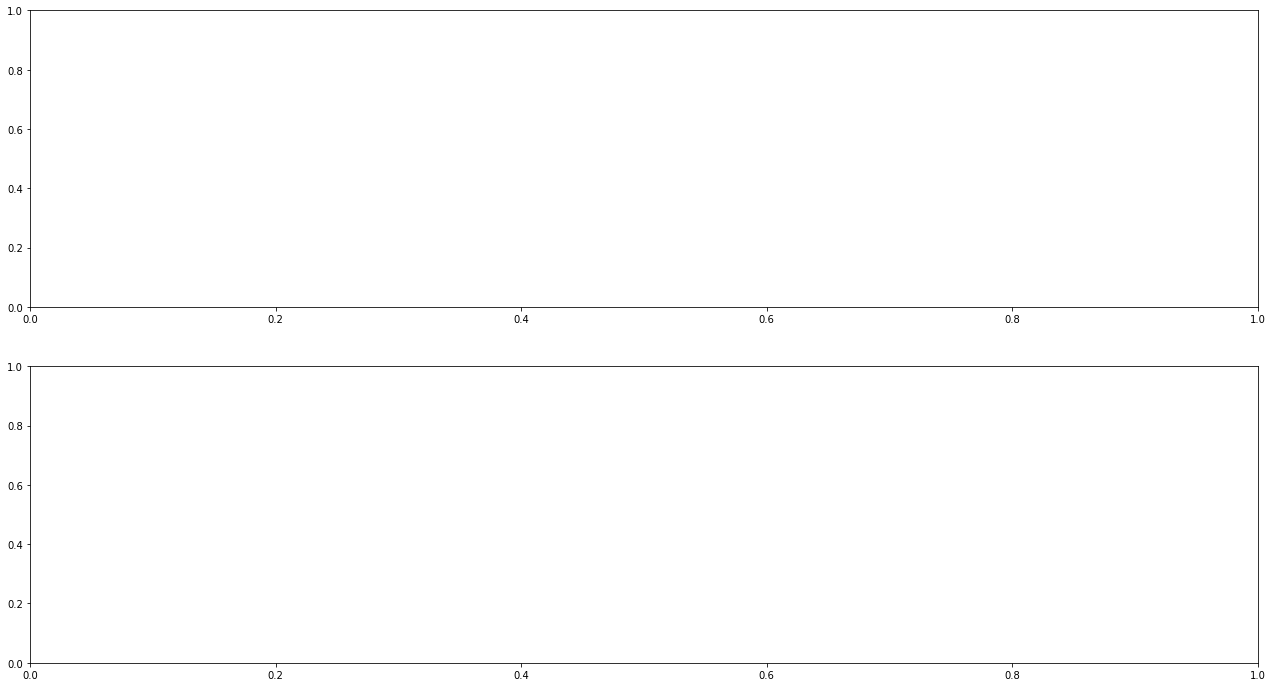

In [0]:
df = data
fig, axs = plt.subplots(2, 1, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination=contamination_factor)
    z = isolation_forest.fit_predict(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
    
    
    anomaly_score = isolation_forest.decision_function(df[column].values.reshape(-1,1))
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)
    


In [0]:
if_vote = z

NameError: ignored

In [0]:
z

NameError: ignored

## DBScan

The challenge is to set *e* value.

In [0]:
def getHyperparameters(sd,retain):
  
  import math
  
  dis=[]
  temp =list(sd['Price'])
  for i in range(0,len(temp)-1):
    dis.append(temp[i+1]-temp[i])

  arr = np.array(dis)
  diss = pd.DataFrame(dis,columns=['dis'])
  std=diss['dis'].std()
  ma = diss['dis'].max()
  n=len(dis)
  
  cnt={}
  unique_dis=list(set(dis))
  for i in unique_dis:
    cnt[i]=dis.count(i)
  keys = cnt.keys()
  keys=sorted(keys)
  cands=[]
  full = int(round((retain*n),0))
  for i in keys:
    full = full - cnt[i]
    cands.append(i)
    if(full<=0):
      break
    
  
  b = pd.DataFrame(cands)
  epsilon = round(np.max(np.array(b))*1000,0)/1000
  return(epsilon)
  



  

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sd = scaler.fit_transform(data)
sd = pd.DataFrame(sd,columns=['Price'])


ValueError: ignored

In [0]:
import math
dis=[]
temp =list(sd['Price'])
for i in range(0,len(temp)-1):
  dis.append(temp[i+1]-temp[i])

arr = np.array(dis)

diss = pd.DataFrame(dis,columns=['dis'])
diss.describe()
std=diss['dis'].std()
ma = diss['dis'].max()
n=len(dis)

In [0]:
cnt={}
unique_dis=list(set(dis))
for i in unique_dis:
  cnt[i]=dis.count(i)
keys = cnt.keys()
keys=sorted(keys)


print(len(keys))

  

In [0]:
cands=[]
full = int(round((0.92*n),0))
for i in keys:
  full = full - cnt[i]
  cands.append(i)
  if(full<=0):
    break
    


In [0]:

b = pd.DataFrame(cands)
b.describe()
epsilon = round(np.max(np.array(b))*1000,0)/1000
epsilon

In [0]:
#main

from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
  eps = epsilon ,
  metric="euclidean",
  min_samples = 3,
  n_jobs = -1)
clusters = outlier_detection.fit_predict(sd)

NameError: ignored

In [0]:
cluster_map = pd.DataFrame()
cluster_map['cluster'] = outlier_detection.labels_
cluster_map[cluster_map.cluster == 0]
clusters[clusters!=-1]=1
dbscan_vote = clusters

In [0]:
dbscan_vote

## LOF

In [0]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=contamination_factor)
y_pred = clf.fit_predict(data)
X_scores = clf.negative_outlier_factor_

lof_vote = y_pred

NameError: ignored

In [0]:
lof_vote

## Autoencoders (To Be Used Later)


To be used later, when more data is available. This would be a semi-supervised learning approach, where <=5% of total data should be labeled. This will greatly improve the accurcy of price range prediction.

In [0]:
#prepare 5-10% labeled data

data=[]
for i in indices:
  data.append(label_data[i])
  
data = np.array(data)
  
  
indices=[]
limit = int(round(0.4*len(t),0))
while(1):
  i = random.randint(0,len(t))
  if(limit<=0):
    break
  if(t[i]!=-1):
    indices.append(i)
    limit = limit - 1
  

NameError: ignored

In [0]:
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam

In [0]:
data =  data.reshape(-1,48)
data

AttributeError: ignored

In [0]:
from sklearn.model_selection import data_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [0]:
input_size = 48

encoding_dim = 24
hidden_dim = int(encoding_dim / 2) 
learning_rate = 1e-7

input_layer = Input(shape=(input_size,))

decoder = Dense(hidden_dim, activation='relu')(input_layer)
decoder = Dense(input_size, activation='linear')(decoder)

autoencoder = Model(input_layer, decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics = ['mean_squared_error'])
autoencoder.summary()

In [0]:
autoencoder.fit(data, data, epochs=300)


NameError: ignored

In [0]:
reconstructed = autoencoder.predict(data)
reconstructed

NameError: ignored

In [0]:
markers = []
checks = list(data - reconstructed)
checks = checks[0]


for i in range(len(checks)):
  if(abs(checks[i])>2):
    markers.append(-1)
  else:
    markers.append(1)

np.array(markers)